# Language Detection

### Import Statements 

In [64]:
import os

import iso639 
import langid
import fasttext
import langdetect
import fasttext.util
from fasttext.FastText import _FastText


from iso639 import *
from langdetect import *
from keras.utils import *
from sklearn.metrics import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


import nbformat
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer

le = LabelEncoder()
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Useful Functions

- Text Cleaning

In [65]:
def clean(Text):
    """
    Clean text by removing newlines, tabs, and double spaces.

    Args:
        text (str or pandas.Series): Text data to clean. If a pandas Series is passed, 
            the cleaning is applied element-wise.

    Returns:
        str or pandas.Series: Cleaned text.

    """
    Text = Text.apply(lambda x: x.replace("\n", " "))
    Text = Text.apply(lambda x: x.replace("\t", " "))
    Text = Text.apply(lambda x: x.replace("  ", " "))
    return Text

- ISO Language Code to Language Name

In [66]:
def iso2str(text):
    '''
    Convert ISO language code to language name in string format.
    
    Args:
        text (str): ISO language code

    Returns:
        str: Language name in string format, or 'unknown' if the code is invalid.
    '''
    try:
        return languages.get(alpha2=text).name
    except:
        return 'unknown'

- LangDetect Prediction

In [67]:
def check_lang(text):
    '''Detects the language of the input text using Langdetect.
    
    Args:
        param text (str) : Input text
    Returns:
        str : Two-letter language code if language is detected, otherwise returns "unknown".
    '''
    try:
        lang = detect(str(text))
    except lang_detect_exception.LangDetectException:
        lang = 'unknown'
    return lang   

- FastText Prediction 

In [68]:
class LanguageIdentification:
    """
    A class for identifying the language of a given input text using a pre-trained fasttext language model.

    Attributes:
        model (fasttext.FastText._FastText): The pre-trained fasttext language model.

    Methods:
        predict_lang(text: str) -> str:
            Identifies the language of the given input text using the pre-trained fasttext language model.
    """

    def __init__(self):
        """
        Initializes the LanguageIdentification class by loading the pre-trained fasttext language model.
        """
        pretrained_lang_model = "../models/lid.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text: str) -> str:
        """
        Identifies the language of the given input text using the pre-trained fasttext language model.

        Args:
            text (str): The input text whose language is to be identified.

        Returns:
            str: The identified language of the input text.
        """
        predictions = self.model.predict(text, k=1) 
        predictions = predictions[0][0].replace("__label__", "")
        return predictions


- Custom Evaluation Report

In [69]:
def multiclass_report(y_true, y_pred, labels):
    '''
    Calculates and displays the accuracy, precision, and recall for the classification of a multiclass problem.

    Args:
        y_true (array-like): True labels for the data.
        y_pred (array-like): Predicted labels for the data.
        labels (list-like): List of unique class labels in the data.

    Returns:
        None

    Prints the accuracy, precision, and recall for the classification.
    Displays a confusion matrix as a heatmap.
    '''
    
    print(f'Accuracy: {np.mean(y_true == y_pred)}\nPrecision: {np.mean(y_true == y_pred)}\nRecall: {np.mean(y_true == y_pred)}')
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

- Embedding using SentenceTransformer 

In [70]:
st = SentenceTransformer('all-MiniLM-L6-v2')

def stEmbedding(text, model = 'model'):
    '''
    Embed the given text using Sentence Transformer.

    Args:
    - text (str): The text to embed.

    Returns:
    numpy.ndarray: The embedding of the input text as a numpy array.

    Raises:
    ValueError: If an unsupported model is specified.
    '''
    return st.encode(text)


- Embedding using FastText

In [71]:
ft = _FastText('../models/lid.bin')
def ftEmbedding(text):
    '''
    Embed the given text using a Fasttext.

    Args:
    - text (str): The text to embed.

    Returns:
    numpy.ndarray: The embedding of the input text as a numpy array.

    Raises:
    ValueError: If an unsupported model is specified.
    '''

    return ft.get_sentence_vector(text)

- T-Stocastic Neighbour Embedding Plot

In [72]:
def Tsen(Embedding, Language, Dimentions):
    '''
    Visualize word embeddings using t-SNE algorithm.

    Args:
        Embedding (pd.DataFrame): DataFrame containing word embeddings.
        Language (pd.Series): Series containing language labels for each word.
        Dimentions (int): Number of dimensions in the output embedding space.

    Returns:
        None

    Displays a scatter plot of the word embeddings in the reduced dimensional space.
    '''
    X = np.array(Embedding.tolist())
    y = Language.values
    X_embedded = TSNE(n_components=Dimentions).fit_transform(X)

    plt.figure(figsize=(10, 10))
    for i, lang in enumerate(Language.unique()):
        plt.scatter(X_embedded[y == lang, 0], X_embedded[y == lang, 1], label=lang)

    plt.legend()
    plt.show()

- Interactive Plot using Plotly 

In [73]:
def Plotly(Embedding, Language, Dimentions):
    '''
    Visualize word embeddings using t-SNE algorithm and Plotly library.

    Args:
        Embedding (pd.DataFrame): DataFrame containing word embeddings.
        Language (pd.Series): Series containing language labels for each word.
        Dimentions (int): Number of dimensions in the output embedding space.

    Returns:
        None

    Displays an interactive scatter plot of the word embeddings in the reduced dimensional space.
    '''
    
    X = np.array(Embedding.tolist())
    y = Language.values

    X_embedded = TSNE(n_components=Dimentions).fit_transform(X)
    fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=y, width=800, height=800)
    fig.show()

- Data Splitting Function 

In [74]:

def split_train_test_data(Embedding, Language):
    '''
    Splits the data into training and testing sets, and applies label encoding to the target variable.

    Args:
    - Embedding (DataFrame): DataFrame containing the embedding vectors.
    - Language (DataFrame): DataFrame containing the target variable.

    Returns:
    - X_train, X_test, y_train, y_test (numpy.ndarray): The training and testing data and target variables.
    '''
    
    X = np.array(Embedding.tolist())

    y = Language.values
    y = LabelEncoder().fit_transform(y)
    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

- All in One Wrapper for creating Custom model _(OLD)_ 

In [75]:
def createModel(model_type, num_layers, layer_types, layer_units, input_shape):
    '''Create a deep learning model with specified architecture.

    Args:
        model_type (str): The type of model to create. Supported values are
            'Sequentials', 'LSTM', and 'Convolutional'.
        num_layers (int): The number of layers to include in the model.
        layer_types (list[str]): A list of layer types to include in the model.
        layer_units (list[int]): A list of the number of units for each layer in the model.
        input_shape (tuple[int]): The shape of the input data.
        output_units (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported model type is specified.
    '''

    model = Sequential()
    if model_type == 'Sequentials':
        for i in range(num_layers):
            if layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")
    
    elif model_type == 'LSTM':
        model.add(Reshape((input_shape[1], 1)))
        for i in range(num_layers):
            if layer_types[i] == 'LSTM':
                model.add(LSTM(layer_units[i], input_shape=input_shape))
            elif layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")

    elif model_type == 'Convolutional1D':
        model.add(Reshape((input_shape[1], 1)))
        for i in range(num_layers):
            if layer_types[i] == 'Conv1D':
                model.add(Conv1D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=input_shape))
            elif layer_types[i] == 'MaxPooling1D':
                model.add(MaxPooling1D(pool_size=2))
            elif layer_types[i] == 'Conv2D':
                model.add(Conv2D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=input_shape))
            elif layer_types[i] == 'MaxPooling2D':
                model.add(MaxPooling2D(pool_size=2))
            elif layer_types[i] == 'Flatten':
                model.add(Flatten())
            elif layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")

    elif model_type == 'Convolutional2D':
        model.add(Reshape((input_shape[1], 1)))
        for i in range(num_layers):
            if layer_types[i] == 'Conv2D':
                model.add(Conv1D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=input_shape))
            elif layer_types[i] == 'MaxPooling2D':
                model.add(MaxPooling1D(pool_size=2))
            elif layer_types[i] == 'Flatten':
                model.add(Flatten())
            elif layer_types[i] == 'Dense':
                model.add(Dense(layer_units[i], activation='relu'))
            elif layer_types[i] == 'Dropout':
                model.add(Dropout(layer_units[i]))
            else:
                raise ValueError(f"Unsupported layer type: {layer_types[i]}")
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    model.add(Dense(17, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
    model.build(input_shape=input_shape)
    model.summary()
    return model


- Multi-layer Perceptron (MLP) Wrapper 

In [76]:
def sequentialModel(numLayers, layerTypes, layerUnits, inputLayer, outputLayer):
    '''Create a deep learning model with Sequenctial architecture.

    Args:
        numLayers (int): The number of layers to include in the model.
        layerTypes (list[str]): A list of layer types to include in the model.
        layerUnits (list[int]): A list of the number of units for each layer in the model.
        inputLayer (tuple[int]): The shape of the input data.
        outputLayer (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported layer type is specified.
    '''
    model = Sequential()
    for i in range(numLayers):
        if layerTypes[i] == 'Dense':
            model.add(Dense(layerUnits[i], activation='relu'))
        elif layerTypes[i] == 'Dropout':
            model.add(Dropout(layerUnits[i]))
        else:
            raise ValueError(f"Unsupported layer type: {layerTypes[i]}")
    model.add(Dense(outputLayer, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


- LSTM Wrapper 

In [77]:
def LSTMModel(numLayers, layerTypes, layerUnits, inputLayer, outputLayer):
    '''Create a deep learning model with LSTM architecture.

    Args:
        numLayers (int): The number of layers to include in the model.
        layerTypes (list[str]): A list of layer types to include in the model.
        layerUnits (list[int]): A list of the number of units for each layer in the model.
        inputLayer (tuple[int]): The shape of the input data.
        outputLayer (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported layer type is specified.
    '''
    model = Sequential()
    for i in range(numLayers):
        if layer_types[i] == 'LSTM':
            model.add(LSTM(layer_units[i], input_shape=inputLayer, return_sequences=True))
        elif layer_types[i] == 'Dense':
            model.add(Dense(layer_units[i], activation='relu'))
        elif layer_types[i] == 'Dropout':
            model.add(Dropout(layer_units[i]))
        else:
            raise ValueError(f"Unsupported layer type: {layerTypes[i]}")
    model.add(Dense(outputLayer, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


- Convolutional Model Wrapper 

In [78]:
def ConvoModel(numLayers, layerTypes, layerUnits, inputLayer, outputLayer):
    '''Create a deep learning model with Convolutional architecture.

    Args:
        numLayers (int): The number of layers to include in the model.
        layerTypes (list[str]): A list of layer types to include in the model.
        layerUnits (list[int]): A list of the number of units for each layer in the model.
        inputLayer (tuple[int]): The shape of the input data.
        outputLayer (int): The number of output units in the final layer of the model.

    Returns:
        tensorflow.keras.models.Model: The compiled deep learning model.

    Raises:
        ValueError: If an unsupported layer type is specified.
    '''
    model = Sequential()
    for i in range(numLayers):
        if layer_types[i] == 'Conv1D':
            model.add(Conv1D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=inputLayer))
        elif layer_types[i] == 'MaxPooling1D':
            model.add(MaxPooling1D(pool_size=2))
        elif layer_types[i] == 'Conv2D':
            model.add(Conv2D(filters=layer_units[i], kernel_size=3, activation='relu', input_shape=inputLayer))
        elif layer_types[i] == 'MaxPooling2D':
            model.add(MaxPooling2D(pool_size=2))
        elif layer_types[i] == 'Flatten':
            model.add(Flatten())
        elif layer_types[i] == 'Dense':
            model.add(Dense(layer_units[i], activation='relu'))
        elif layer_types[i] == 'Dropout':
            model.add(Dropout(layer_units[i]))
        else:
            raise ValueError(f"Unsupported layer type: {layerTypes[i]}")
    model.add(Dense(outputLayer, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

- Model Training 

In [79]:
def TrainModel(model, epochs, name, X_train, X_test, y_train, y_test):
    '''
    Train the deep learning model and evaluate its performance

    Args:
    - model : the deep learning model object
    - epochs : the number of epochs to train the model
    - name : the name of the file to save the trained model
    - X_train : the input training data
    - X_test : the input testing data
    - y_train : the target training labels
    - y_test : the target testing labels

    Returns:
    None
    '''

    if not os.path.exists('../models/' + name + '.h5'):
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
        model.save('../models/' + name + '.h5')
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        epoch(history, y_test, y_pred)
        modelEval(y_test, y_pred)
    else:
        model.load_weights('../models/' + name + '.h5')
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        modelEval(y_test, y_pred)

- Deeplearning Evaluation 

In [80]:
def modelEval(y_test, y_pred):
    """
    Evaluate the model performance using various metrics and plot a confusion matrix.

    Args:
        y_test (numpy array): True labels of the test data in one-hot encoding format
        y_pred (numpy array): Predicted labels of the test data in categorical format

    Returns:
        None
    """


    y_test = np.argmax(y_test, axis=1)

    xtick = df['Language'].unique()
    ytick = df['Language'].unique()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'Accuracy\t:\t{accuracy}')
    print(f'Precision\t:\t{precision}')
    print(f'Recall\t:\t{recall}')
    print(f'F1 score\t:\t{f1}')

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=xtick, yticklabels=ytick)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


- Training Plots

In [81]:
def epoch(history, y_test, y_pred):
    '''
    Plot accuracy and loss values during training and validation as a function of epochs.

    Args:
        history (keras.callbacks.History): Object returned by fit() containing information about the training history.

    Returns:
        None

    Displays two plots:
    1. Accuracy vs Epochs: shows the training and validation accuracy values as a function of epochs.
    2. Loss vs Epochs: shows the training and validation loss values as a function of epochs.
    '''
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs Graph')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs Graph')
    plt.legend()
    plt.show()


## Using Pre-built Libraries

In [82]:
df = pd.read_csv('../data/Language.csv')
df.head()

Text Language
0   Nature, in the broadest sense, is the natural...  English
1  "Nature" can refer to the phenomena of the phy...  English
2  The study of nature is a large, if not the onl...  English
3  Although humans are part of nature, human acti...  English
4  [1] The word nature is borrowed from the Old F...  English

- LangDetect


Using Langdetect
Accuracy: 0.7890103511657154
Precision: 0.7890103511657154
Recall: 0.7890103511657154


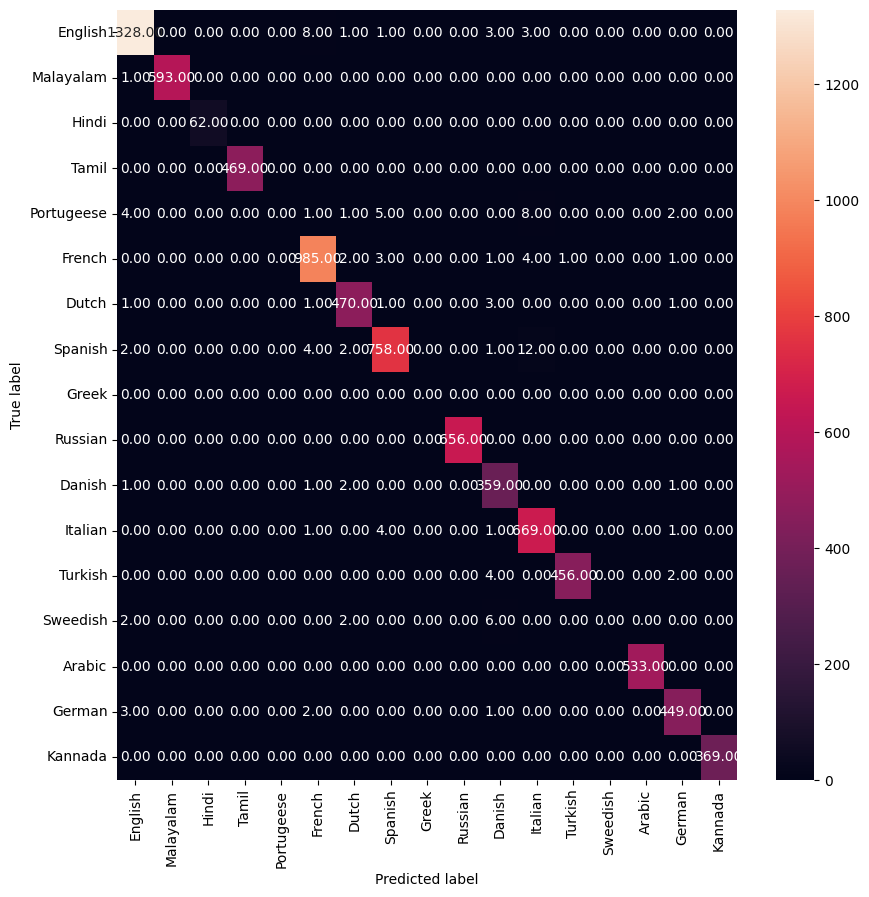

In [83]:
print("Using Langdetect")
df['langdetect'] = df['Text'].apply(check_lang)
df['langdetect'] = df['langdetect'].apply(iso2str)
multiclass_report(df['Language'], df['langdetect'], df['Language'].unique())


- LangId


Using Langid
Accuracy: 0.7907516687626971
Precision: 0.7907516687626971
Recall: 0.7907516687626971


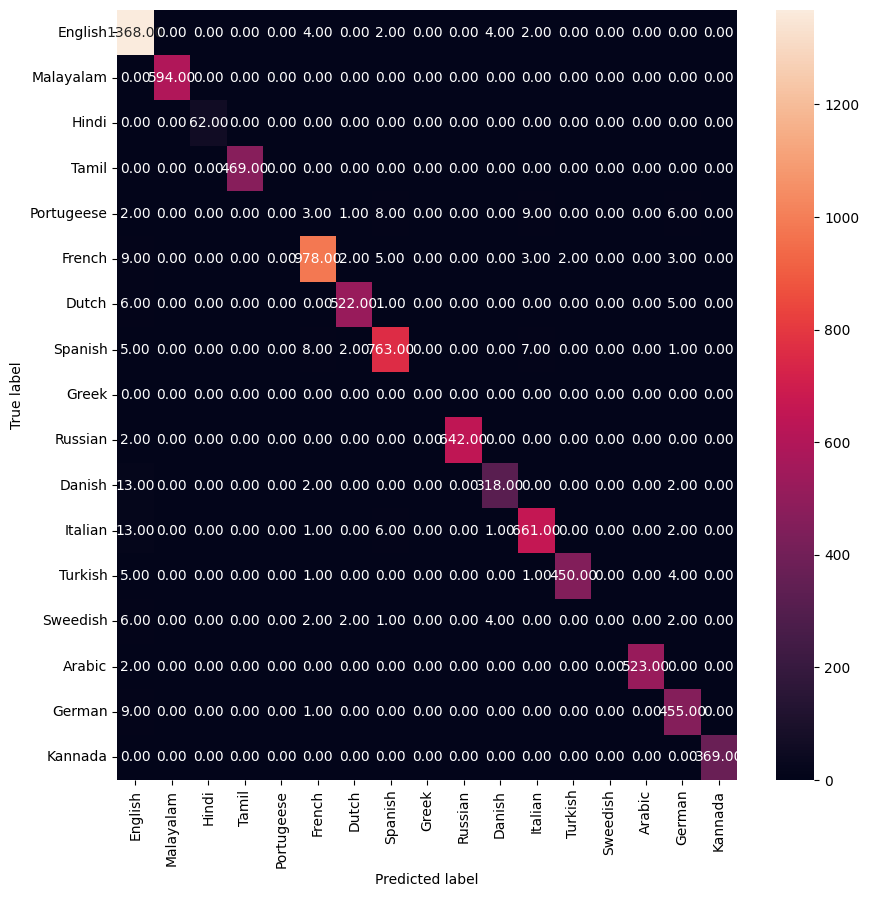

In [84]:
print("Using Langid")
df['langid'] = df['Text'].apply(langid.classify)
df['langid'] = df['langid'].apply(lambda x: x[0])
df['langid'] = df['langid'].apply(iso2str)
multiclass_report(df['Language'], df['langid'], df['Language'].unique())

- FastText

Using Fasttext
Accuracy: 0.8179355712489117
Precision: 0.8179355712489117
Recall: 0.8179355712489117


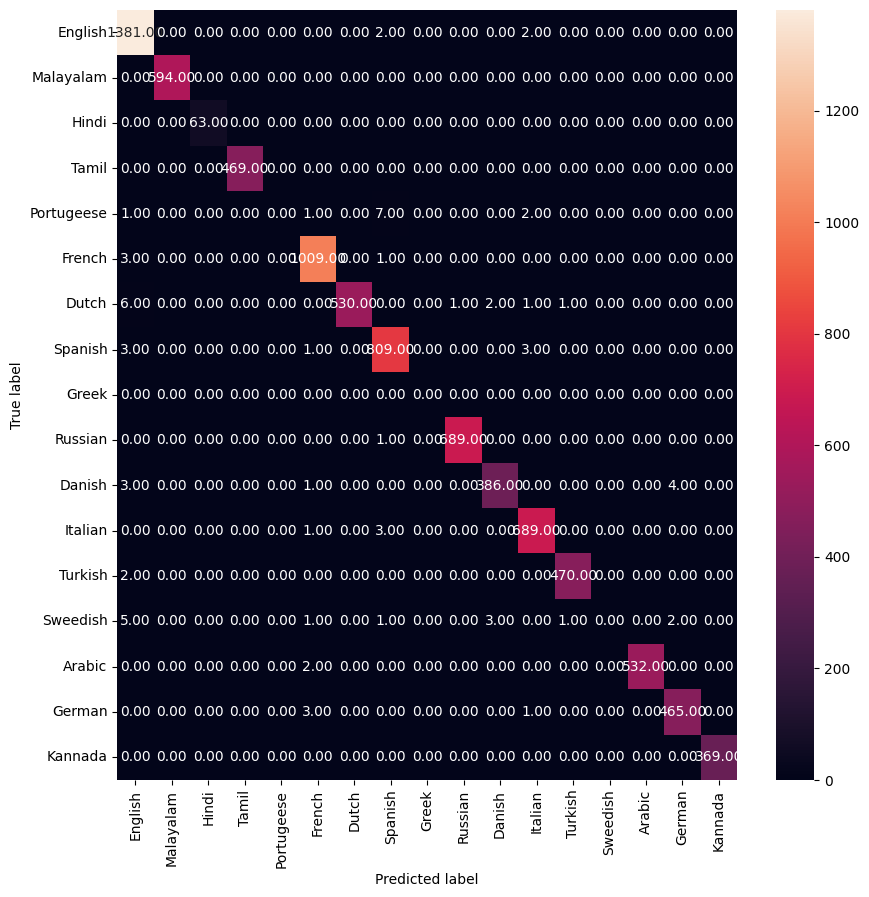

In [85]:
model = LanguageIdentification()

print("Using Fasttext")
df['Text'] = df['Text'].apply(lambda x: x.replace("\n", " "))
df['fasttext'] = df['Text'].apply(model.predict_lang)
df['fasttext'] = df['fasttext'].apply(iso2str)
multiclass_report(df['Language'], df['fasttext'], df['Language'].unique())

## Using Embeddings

### Using SentenceTransformer

In [86]:
df = pd.read_csv('../data/Language.csv')
df['Text'] = clean(df['Text'])

df['Embedding'] = df['Text'].apply(stEmbedding)


In [87]:
df.head()

Text Language   
0   Nature, in the broadest sense, is the natural...  English  \
1  "Nature" can refer to the phenomena of the phy...  English   
2  The study of nature is a large, if not the onl...  English   
3  Although humans are part of nature, human acti...  English   
4  [1] The word nature is borrowed from the Old F...  English   

                                           Embedding  
0  [0.06381069, -0.020321652, 0.022865318, 0.0803...  
1  [0.04028564, 0.013012324, 0.010959669, 0.13800...  
2  [0.073503, 0.061530456, 0.083170004, 0.0722697...  
3  [0.049719308, -0.046503387, 0.066873305, 0.047...  
4  [0.026049394, 0.031227034, 0.0108607905, 0.117...

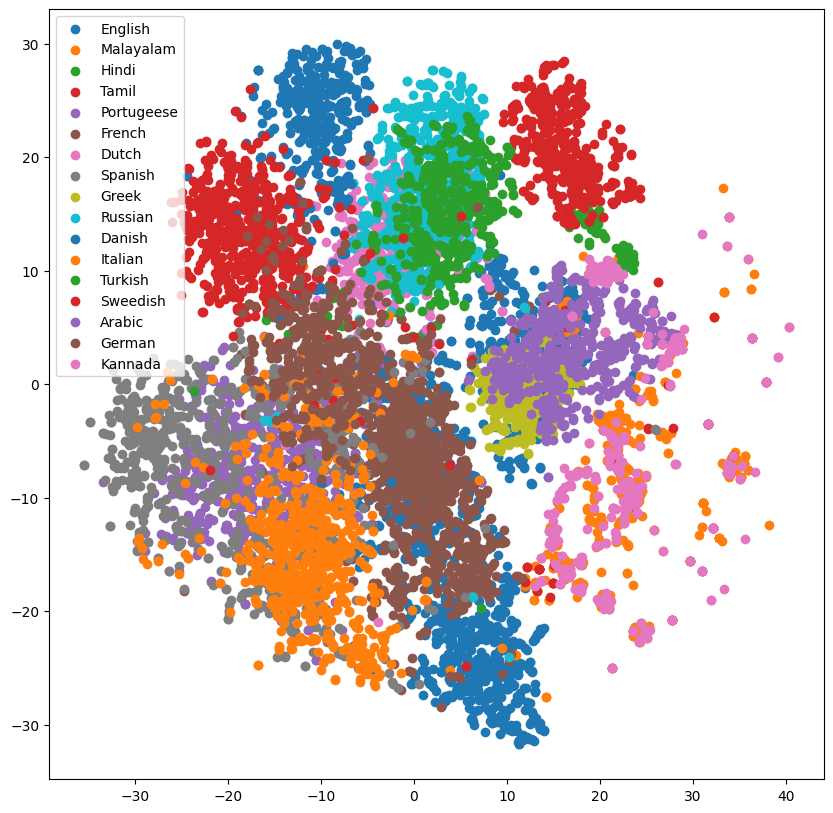

In [88]:
Tsen(df['Embedding'], df['Language'], 3)

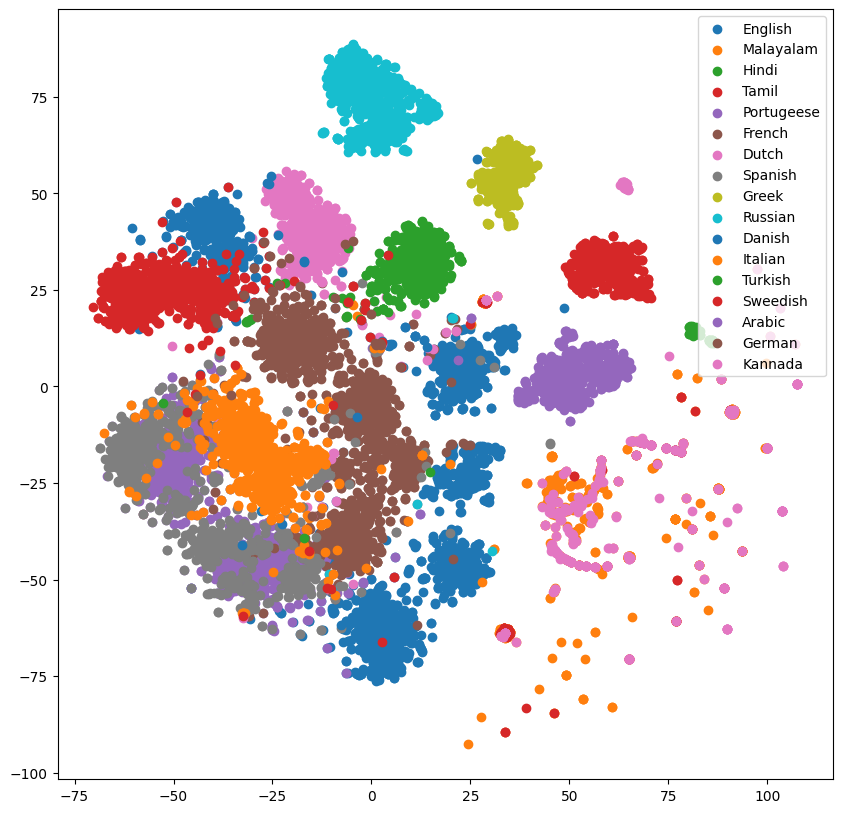

In [89]:
Tsen(df['Embedding'], df['Language'], 2)

In [90]:
Plotly(df['Embedding'], df['Language'], 3)

In [91]:
Plotly(df['Embedding'], df['Language'], 2)

In [92]:
X_train, X_test, y_train, y_test = split_train_test_data(df['Embedding'], df['Language'])

#### Multi-Layer Perceptron

- Model : 1

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 17)                6545      
                                                                 
Total params: 6,545
Trainable params: 6,545
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 910us/step
Accuracy	:	0.9400386847195358
Precision	:	0.9451788049090231
Recall	:	0.9400386847195358
F1 score	:	0.9360863256218458


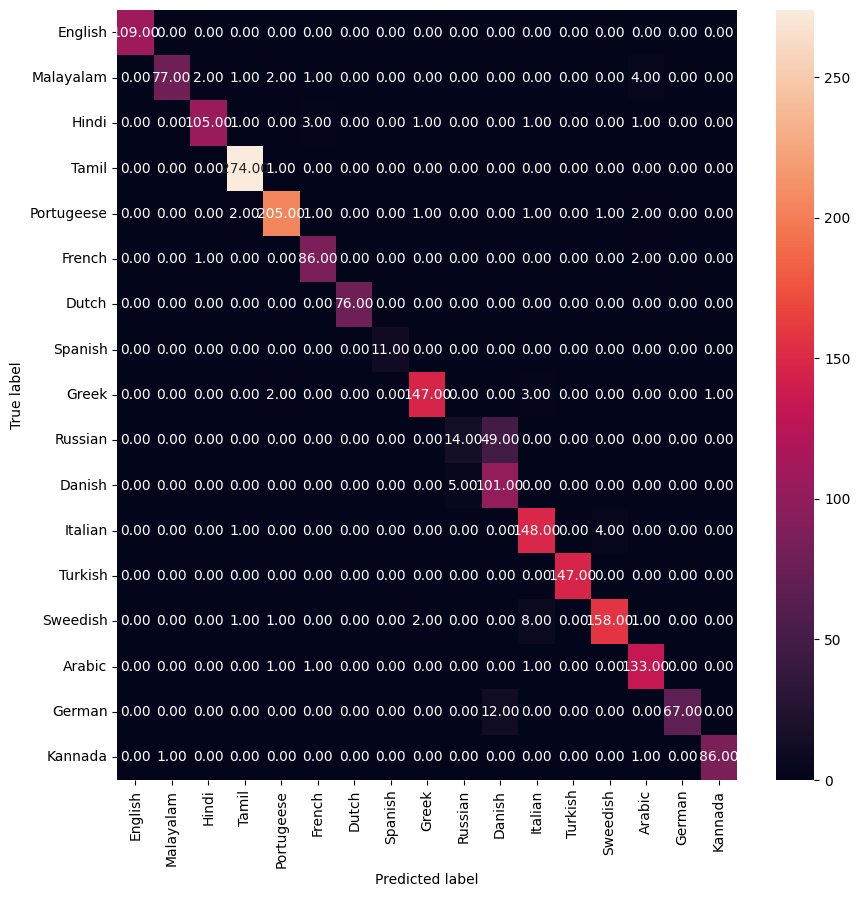

In [93]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=0, 
    layer_types=[], 
    layer_units=[], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_MLP1', X_train, X_test, y_train, y_test)


- Model : 2

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 128)               49280     
                                                                 
 dense_46 (Dense)            (None, 17)                2193      
                                                                 
Total params: 51,473
Trainable params: 51,473
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 814us/step
Accuracy	:	0.9516441005802708
Precision	:	0.9630890542709496
Recall	:	0.9516441005802708
F1 score	:	0.9528283134046381


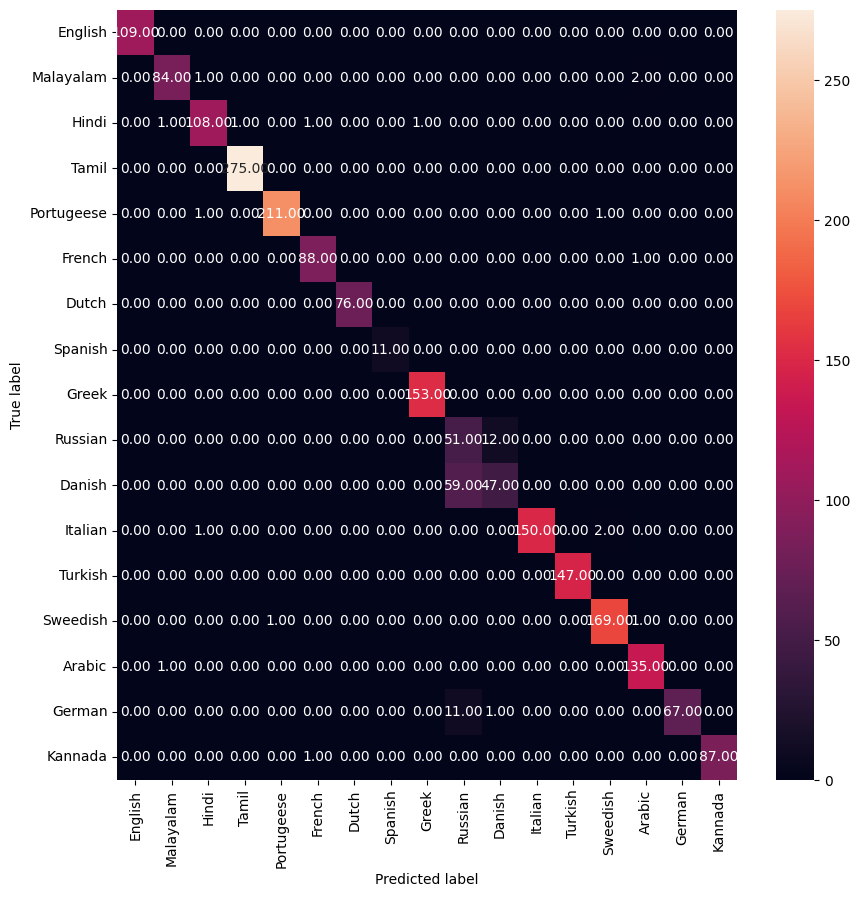

In [94]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=1, 
    layer_types=['Dense'], 
    layer_units=[128], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_MLP2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 128)               49280     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 17)                2193      
                                                                 
Total params: 51,473
Trainable params: 51,473
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 761us/step
Accuracy	:	0.9608317214700194
Precision	:	0.962463154388323
Recall	:	0.9608317214700194
F1 score	:	0.9591567752130248


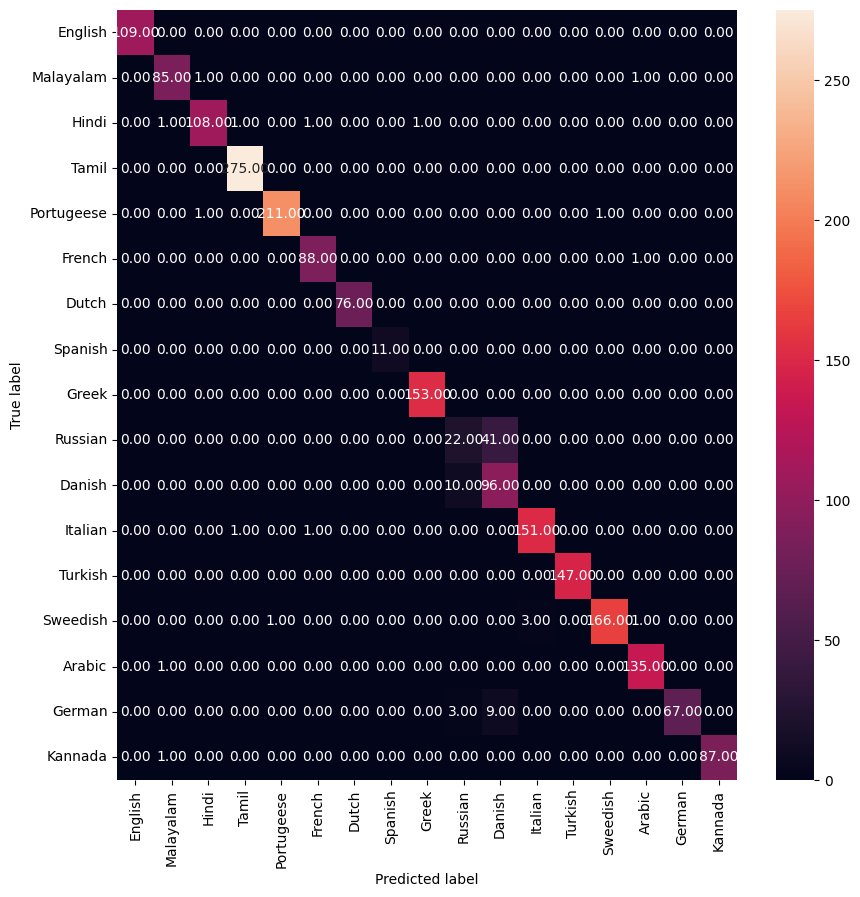

In [95]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=2, 
    layer_types=['Dense', 'Dropout'], 
    layer_units=[128, 0.2], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_MLP3', X_train, X_test, y_train, y_test)


- Model : 4

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 128)               49280     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_50 (Dense)            (None, 64)                8256      
                                                                 
 dense_51 (Dense)            (None, 17)                1105      
                                                                 
Total params: 58,641
Trainable params: 58,641
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 798us/step
Accuracy	:	0.9622823984526112
Precision	:	0.9636743837996068
Recall	:	0.9622823984526112
F1 score	:	0.9611283185494061


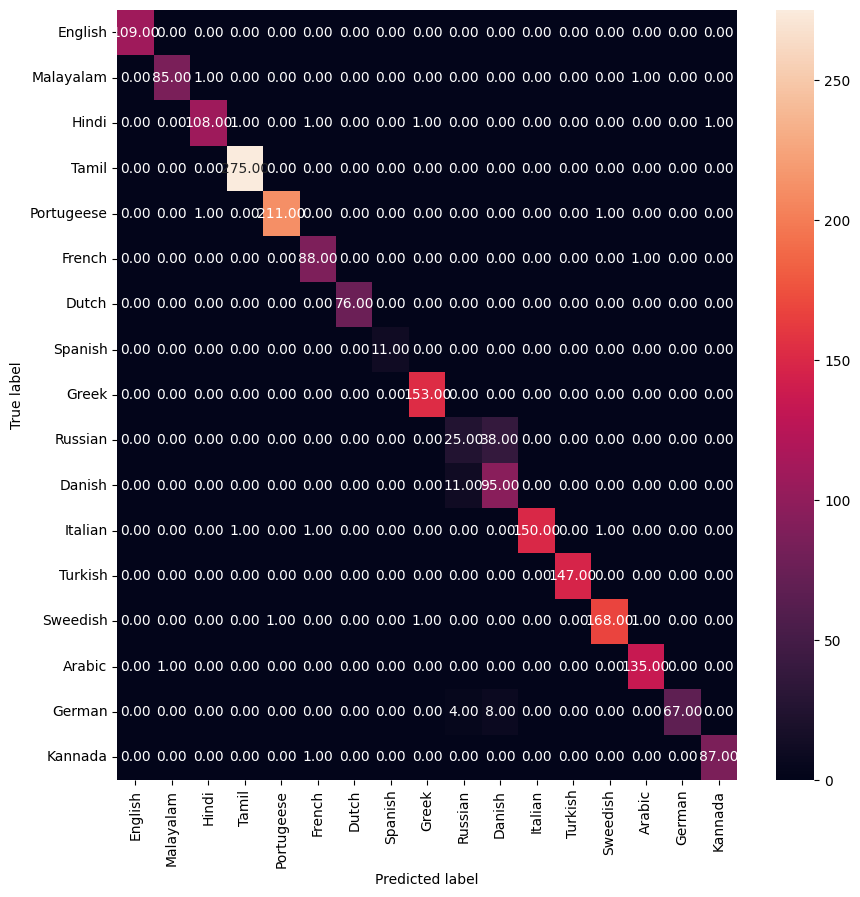

In [96]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=3, 
    layer_types=['Dense', 'Dropout', 'Dense'], 
    layer_units=[128, 0.2, 64], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_MLP4', X_train, X_test, y_train, y_test)


- Model : 5

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 128)               49280     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 17)                1105      
                                                                 
Total params: 58,641
Trainable params: 58,641
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 893us

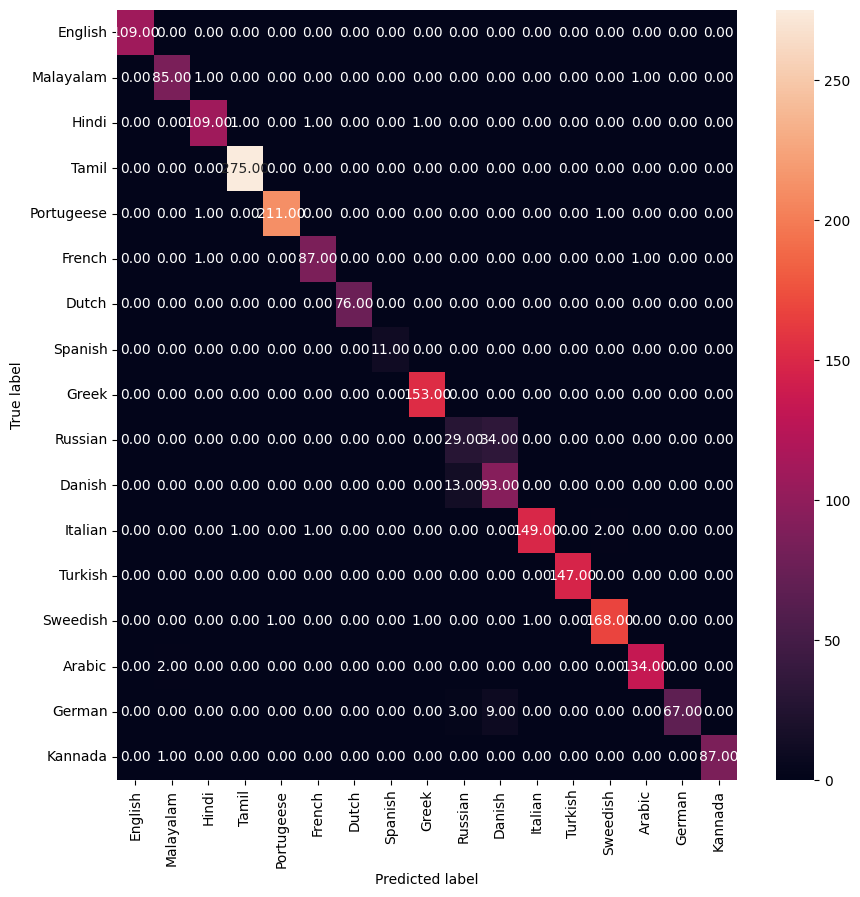

In [97]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=4, 
    layer_types=['Dense', 'Dropout', 'Dense', 'Dropout'], 
    layer_units=[128, 0.2, 64, 0.2], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_MLP5', X_train, X_test, y_train, y_test)


#### Long Short Term Memory

- Model : 1

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_18 (Reshape)        (None, 384, 1)            0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                16896     
                                                                 
 dense_55 (Dense)            (None, 17)                1105      
                                                                 
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
_________________________________________________________________


2023-05-03 21:23:50.528437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:23:50.529709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:23:50.530865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 3/65 [>.............................] - ETA: 1s 

2023-05-03 21:23:50.769194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:23:50.770899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:23:50.772294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 2s 27ms/step
Accuracy	:	0.6049323017408124
Precision	:	0.6064997838215334
Recall	:	0.6049323017408124
F1 score	:	0.5955311124156659


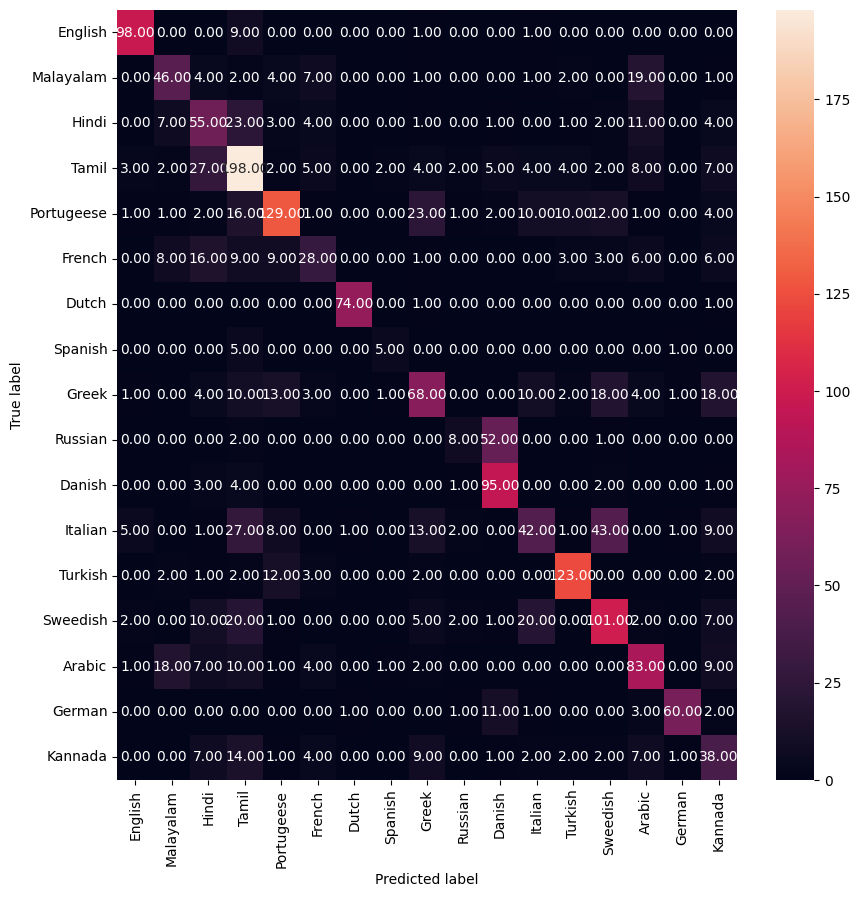

In [98]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=1, 
    layer_types=['LSTM'], 
    layer_units=[64], 
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_LSTM1', X_train, X_test, y_train, y_test)

- Model : 2

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_19 (Reshape)        (None, 384, 1)            0         
                                                                 
 lstm_12 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_56 (Dense)            (None, 17)                1105      
                                                                 
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
_________________________________________________________________


2023-05-03 21:23:53.556395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:23:53.557749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:23:53.558774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/65 [..............................] - ETA: 20s

2023-05-03 21:23:53.792729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:23:53.794263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:23:53.795434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 2s 27ms/step
Accuracy	:	0.6300773694390716
Precision	:	0.6293683808180192
Recall	:	0.6300773694390716
F1 score	:	0.615456873299893


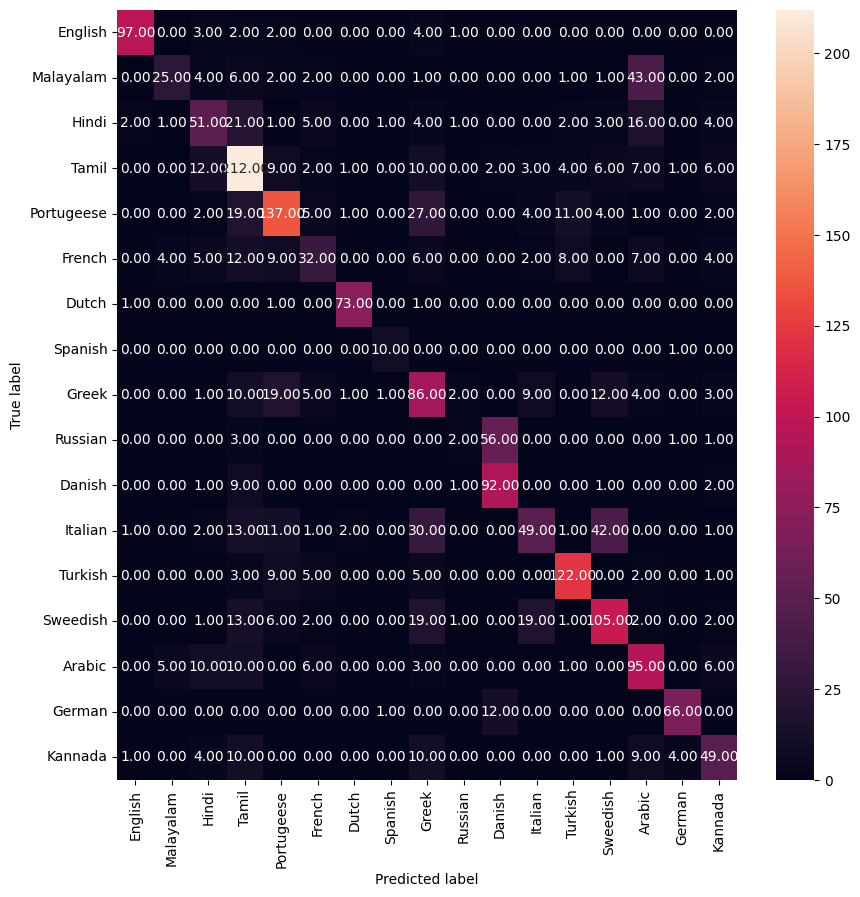

In [99]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=2, 
    layer_types=['LSTM', 'Dropout'],
    layer_units=[64, 0.2],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_LSTM2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_20 (Reshape)        (None, 384, 1)            0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 32)                2080      
                                                                 
 dense_58 (Dense)            (None, 17)                561       
                                                                 
Total params: 19,537
Trainable params: 19,537
Non-trainable params: 0
_________________________________________________________________


2023-05-03 21:23:56.873009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:23:56.874653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:23:56.875608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 3/65 [>.............................] - ETA: 1s 

2023-05-03 21:23:57.112055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:23:57.113830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:23:57.114836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 2s 27ms/step
Accuracy	:	0.6320116054158608
Precision	:	0.6358279712824205
Recall	:	0.6320116054158608
F1 score	:	0.6173094847485057


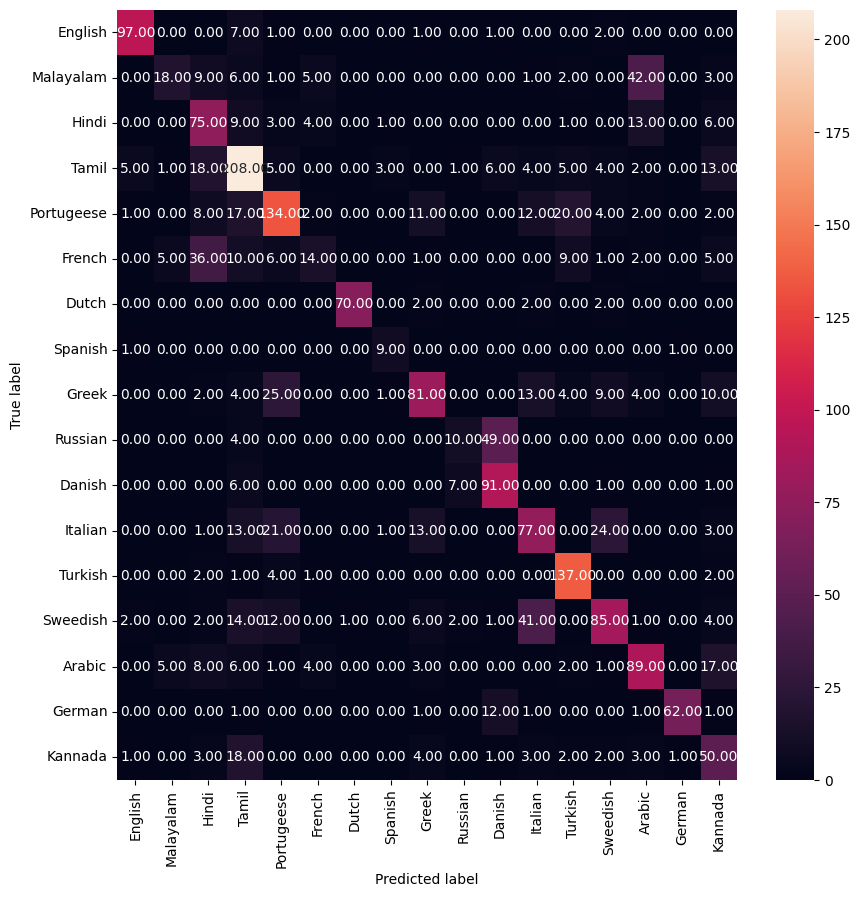

In [100]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=3, 
    layer_types=['LSTM', 'Dropout', 'Dense'],
    layer_units=[64, 0.2, 32],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_LSTM3', X_train, X_test, y_train, y_test)


- Model : 4

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_21 (Reshape)        (None, 384, 1)            0         
                                                                 
 lstm_14 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 32)                2080      
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_60 (Dense)            (None, 17)                561       
                                                                 
Total params: 19,537
Trainable params: 19,537
Non-tra

2023-05-03 21:23:59.963215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:23:59.965058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:23:59.966195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/65 [..............................] - ETA: 20s

2023-05-03 21:24:00.221173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:24:00.222682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:24:00.223692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 2s 28ms/step
Accuracy	:	0.624274661508704
Precision	:	0.6062390665644775
Recall	:	0.624274661508704
F1 score	:	0.6035545055186392


/home/arrry/anaconda3/envs/Language/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



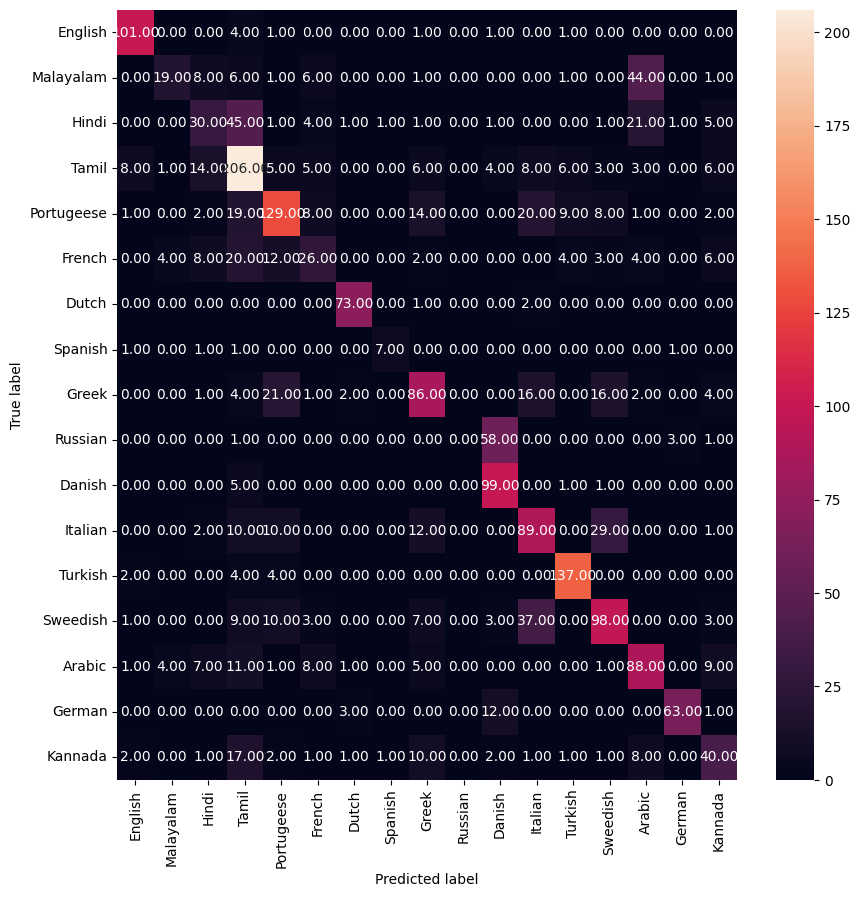

In [101]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=4, 
    layer_types=['LSTM', 'Dropout', 'Dense', 'Dropout'],
    layer_units=[64, 0.2, 32, 0.2],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_LSTM4', X_train, X_test, y_train, y_test)

#### Convolutional Neural Network

- Model : 1

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_22 (Reshape)        (None, 384, 1)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 382, 64)           256       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 191, 64)          0         
 g1D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 191, 64)           0         
                                                                 
 flatten_7 (Flatten)         (None, 12224)             0         
                                                                 
 dense_61 (Dense)            (None, 17)                207825    
                                                     

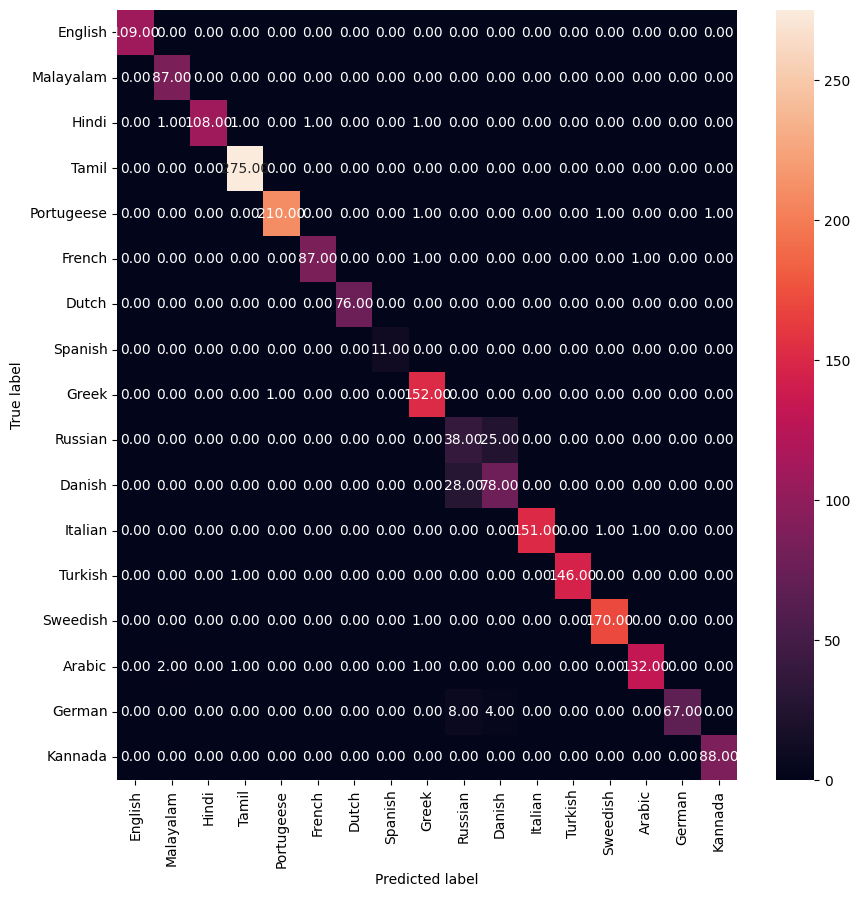

In [102]:
model = createModel(
    model_type = 'Convolutional1D', 
    num_layers=4, 
    layer_types=['Conv1D', 'MaxPooling1D', 'Dropout', 'Flatten'],
    layer_units=[64, 2, 0.2, 32],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_CNN1', X_train, X_test, y_train, y_test)

- Model : 2

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_23 (Reshape)        (None, 384, 1)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 382, 64)           256       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 191, 64)          0         
 g1D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 191, 64)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 189, 64)           12352     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 94, 64)           0         
 g1D)                                                

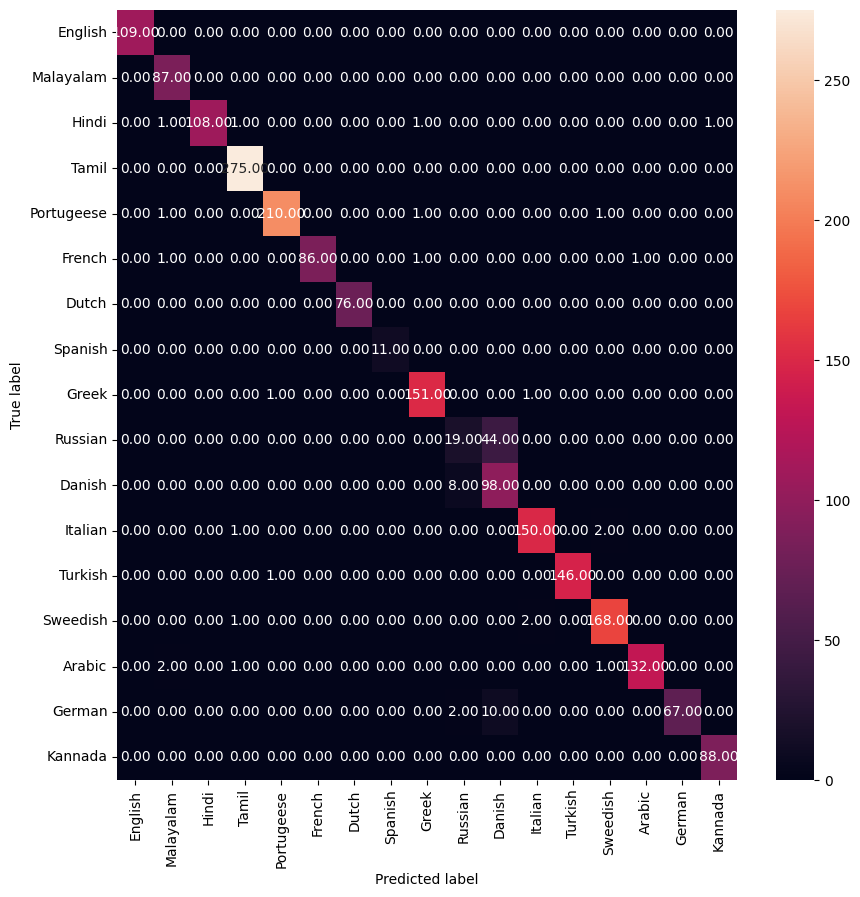

In [103]:
model = createModel(
    model_type = 'Convolutional1D', 
    num_layers=6, 
    layer_types=['Conv1D', 'MaxPooling1D', 'Dropout', 'Conv1D', 'MaxPooling1D', 'Flatten'],
    layer_units=[64, 2, 0.2, 64, 2],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_CNN2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_24 (Reshape)        (None, 384, 1)            0         
                                                                 
 conv1d_14 (Conv1D)          (None, 382, 64)           256       
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 191, 64)          0         
 g1D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 191, 64)           0         
                                                                 
 flatten_9 (Flatten)         (None, 12224)             0         
                                                                 
 dense_63 (Dense)            (None, 17)                207825    
                                                     

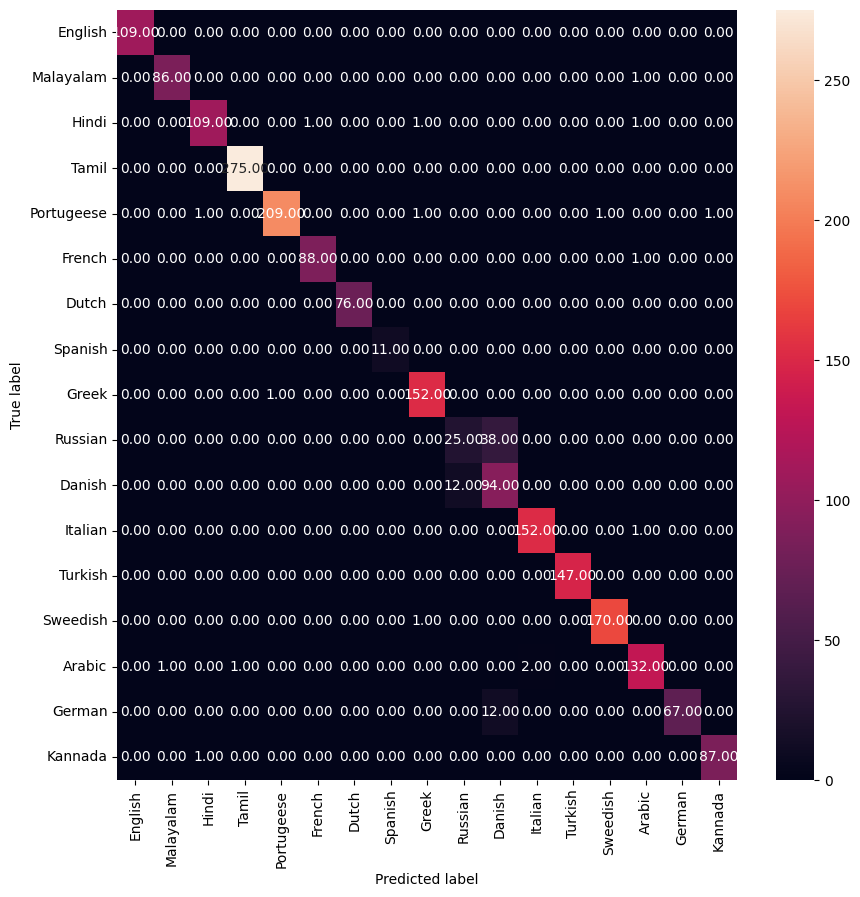

In [104]:
model = createModel(
    model_type = 'Convolutional2D', 
    num_layers=4, 
    layer_types=['Conv2D', 'MaxPooling2D', 'Dropout', 'Flatten'],
    layer_units=[64, 2, 0.2, 32],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_CNN3', X_train, X_test, y_train, y_test)

- Model : 4

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_25 (Reshape)        (None, 384, 1)            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 382, 64)           256       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 191, 64)          0         
 g1D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 191, 64)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 189, 64)           12352     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 94, 64)           0         
 g1D)                                                

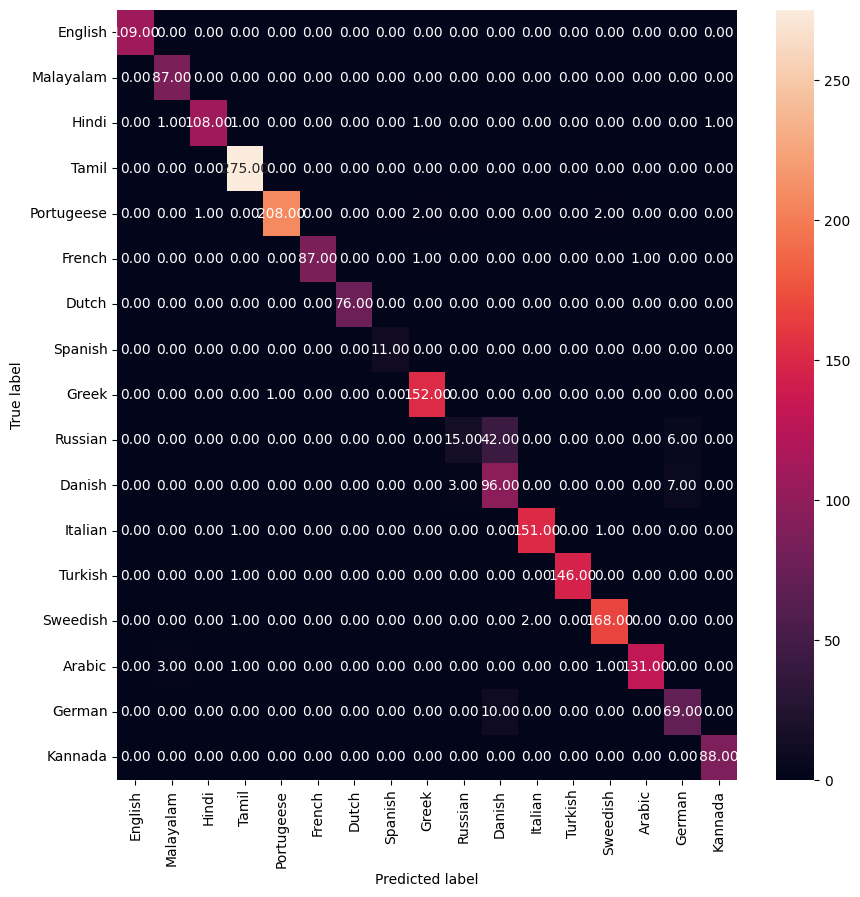

In [105]:
model = createModel(
    model_type = 'Convolutional2D', 
    num_layers=6, 
    layer_types=['Conv2D', 'MaxPooling2D', 'Dropout', 'Conv2D', 'MaxPooling2D', 'Flatten'],
    layer_units=[64, 2, 0.2, 64, 2],
    input_shape=(None, 384), 
)

TrainModel(model, 25, 'ST_CNN4', X_train, X_test, y_train, y_test)

### Using FastText

In [106]:
df = pd.read_csv('../data/Language.csv')
df['Text'] = clean(df['Text'])


df['Embedding'] = df['Text'].apply(ftEmbedding)

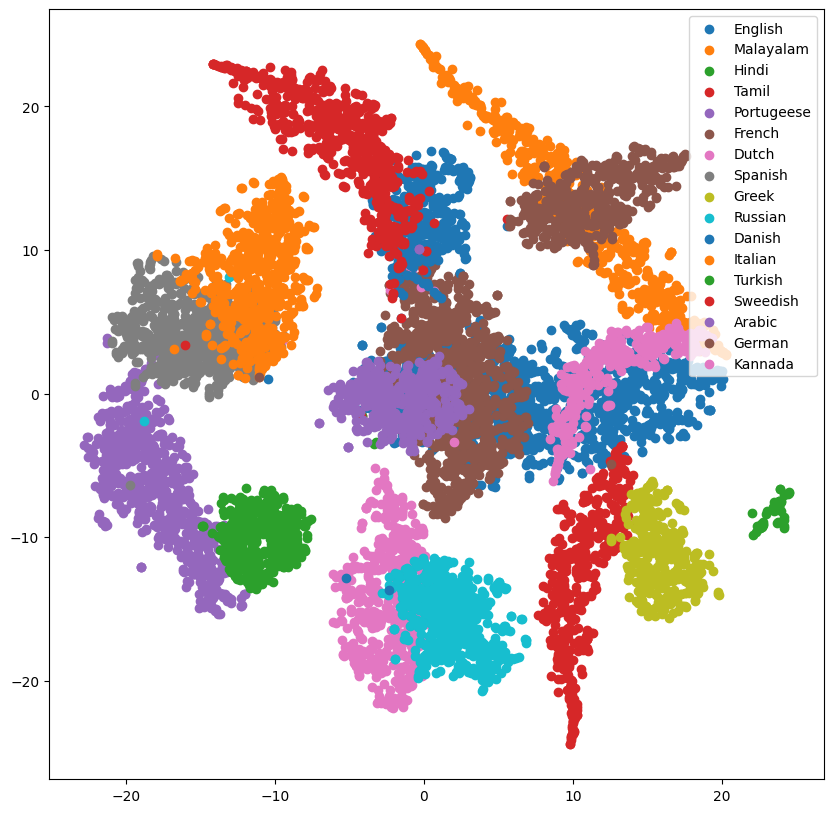

In [107]:
Tsen(df['Embedding'], df['Language'], 3)

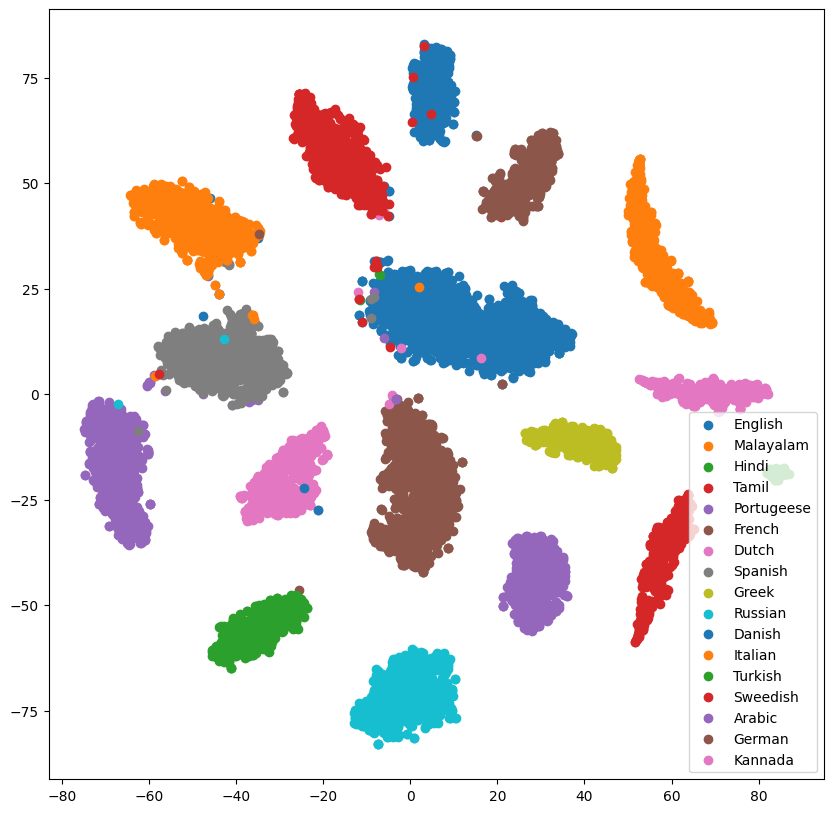

In [108]:
Tsen(df['Embedding'], df['Language'], 2)

In [109]:
Plotly(df['Embedding'], df['Language'], 3)

In [110]:
Plotly(df['Embedding'], df['Language'], 2)

In [111]:
X_train, X_test, y_train, y_test = split_train_test_data(df['Embedding'], df['Language'])

#### Multi-Layer Perceptron

- Model: 1

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 17)                289       
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 781us/step
Accuracy	:	0.9927466150870407
Precision	:	0.9928802496639194
Recall	:	0.9927466150870407
F1 score	:	0.9927619719155559


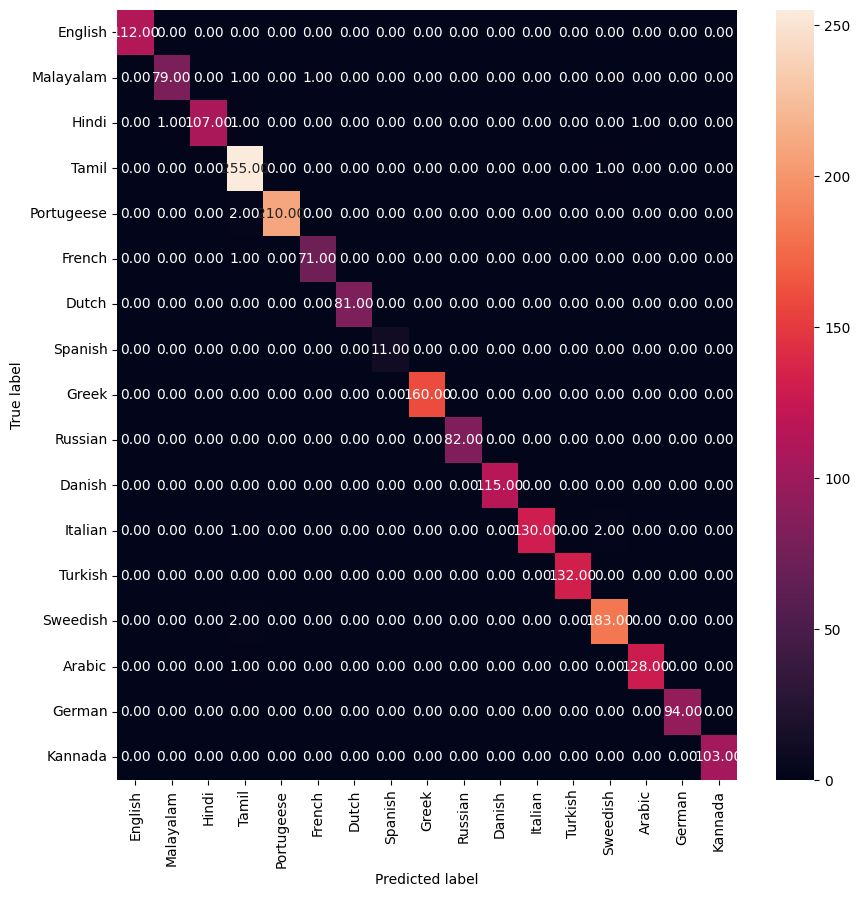

In [112]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=0, 
    layer_types=[], 
    layer_units=[], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_MLP1', X_train, X_test, y_train, y_test)

- Model : 2

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 128)               2176      
                                                                 
 dense_67 (Dense)            (None, 17)                2193      
                                                                 
Total params: 4,369
Trainable params: 4,369
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 694us/step
Accuracy	:	0.9980657640232108
Precision	:	0.9980716610841157
Recall	:	0.9980657640232108
F1 score	:	0.9980661433170405


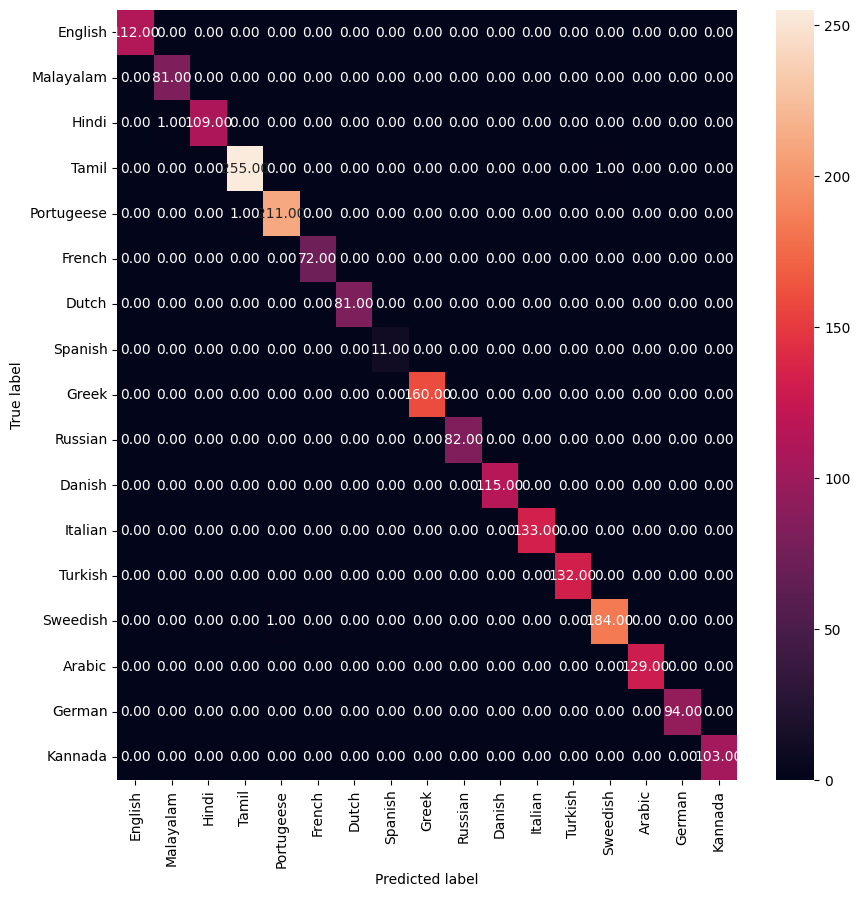

In [113]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=1, 
    layer_types=['Dense'], 
    layer_units=[128], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_MLP2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 128)               2176      
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_69 (Dense)            (None, 17)                2193      
                                                                 
Total params: 4,369
Trainable params: 4,369
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 713us/step
Accuracy	:	0.9970986460348162
Precision	:	0.9971134623393691
Recall	:	0.9970986460348162
F1 score	:	0.9970976692499507


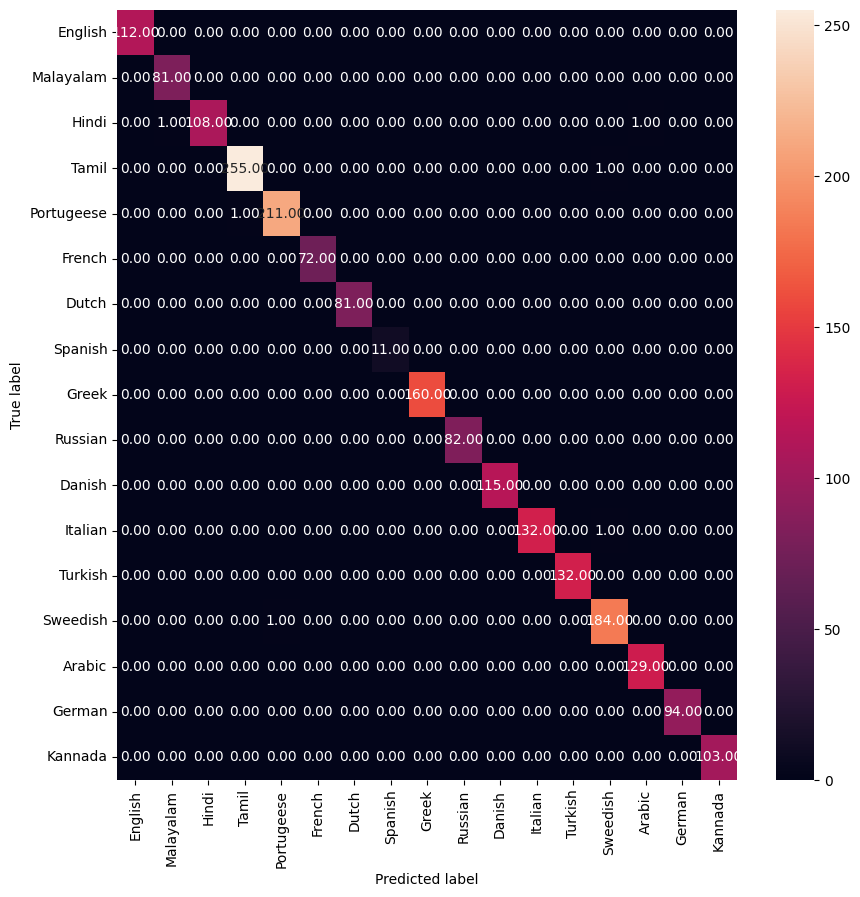

In [114]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=2, 
    layer_types=['Dense', 'Dropout'], 
    layer_units=[128, 0.2], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_MLP3', X_train, X_test, y_train, y_test)

- Model : 4

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 128)               2176      
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense_71 (Dense)            (None, 64)                8256      
                                                                 
 dense_72 (Dense)            (None, 17)                1105      
                                                                 
Total params: 11,537
Trainable params: 11,537
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 726us/step
Accuracy	:	0.9985493230174082
Precision	:	0.9985493230174082
Recall	:	0.9985493230174082
F1 score	:	0.9985493230174082


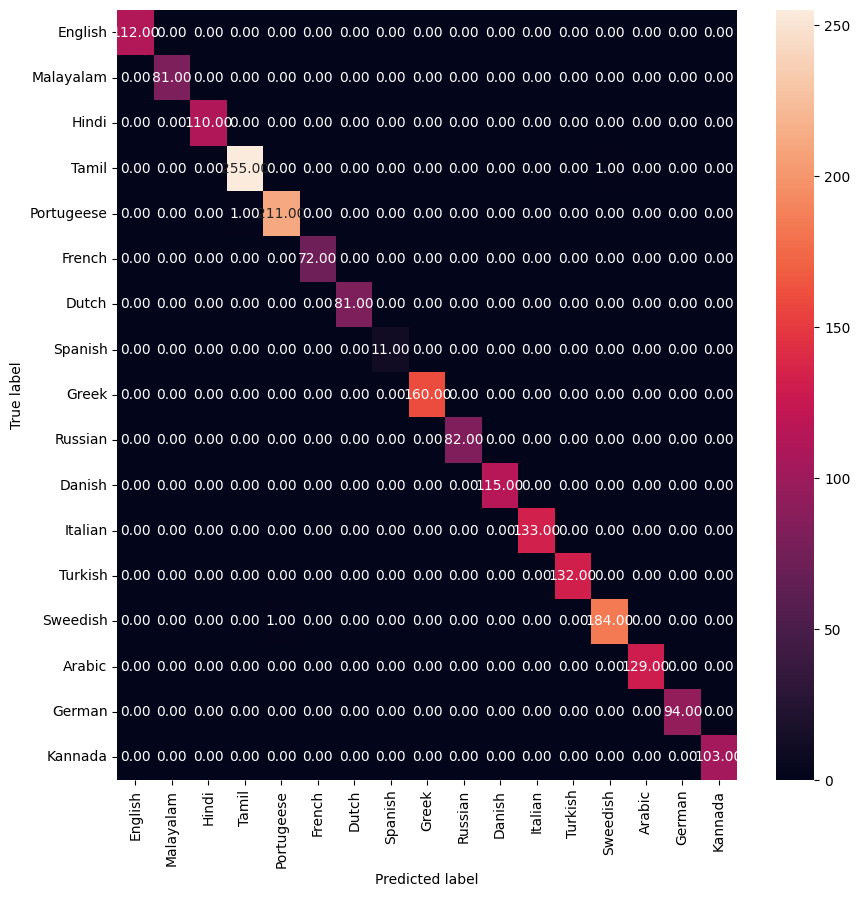

In [115]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=3, 
    layer_types=['Dense', 'Dropout', 'Dense'], 
    layer_units=[128, 0.2, 64], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_MLP4', X_train, X_test, y_train, y_test)

- Model : 5

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 128)               2176      
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_74 (Dense)            (None, 64)                8256      
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_75 (Dense)            (None, 17)                1105      
                                                                 
Total params: 11,537
Trainable params: 11,537
Non-trainable params: 0
_________________________________________________________________
65/65 [==============================] - 0s 860us

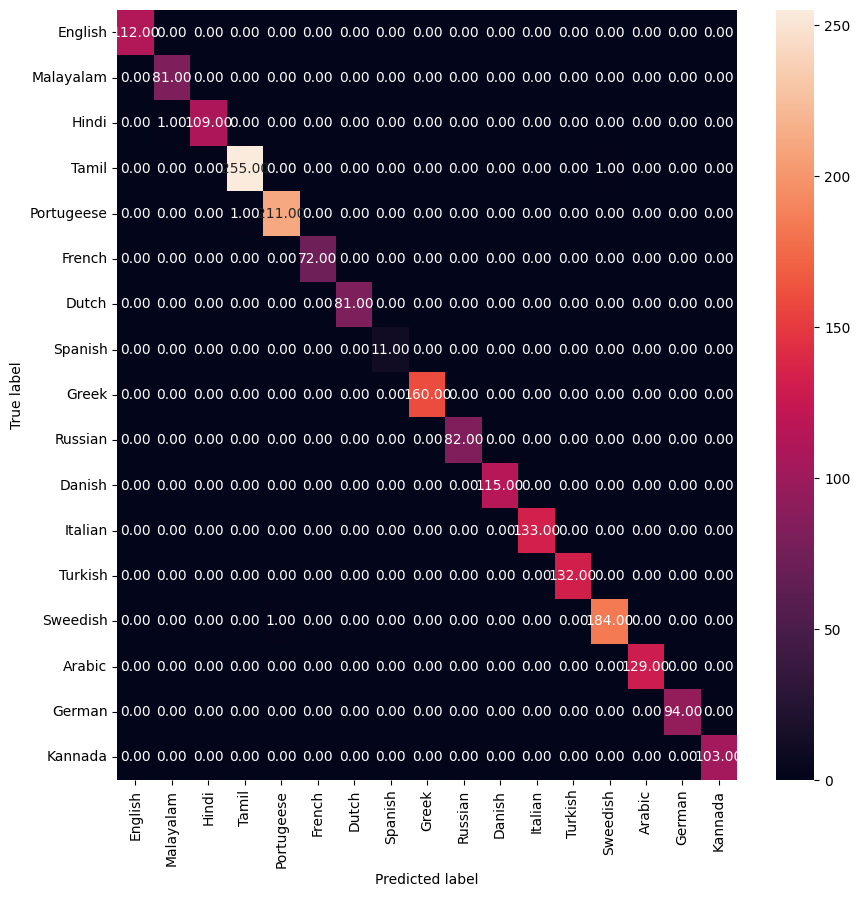

In [116]:
model = createModel(
    model_type = 'Sequentials', 
    num_layers=4, 
    layer_types=['Dense', 'Dropout', 'Dense', 'Dropout'], 
    layer_units=[128, 0.2, 64, 0.2], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_MLP5', X_train, X_test, y_train, y_test)

#### Long Short Term Memory

- Model : 1

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_26 (Reshape)        (None, 16, 1)             0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                16896     
                                                                 
 dense_76 (Dense)            (None, 17)                1105      
                                                                 
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
_________________________________________________________________


2023-05-03 21:28:20.366656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:28:20.368327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:28:20.369614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/65 [===========>..................] - ETA: 0s 

2023-05-03 21:28:20.601616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:28:20.603194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:28:20.604191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 0s 2ms/step
Accuracy	:	0.9854932301740812
Precision	:	0.9858615653789071
Recall	:	0.9854932301740812
F1 score	:	0.9855586941437026


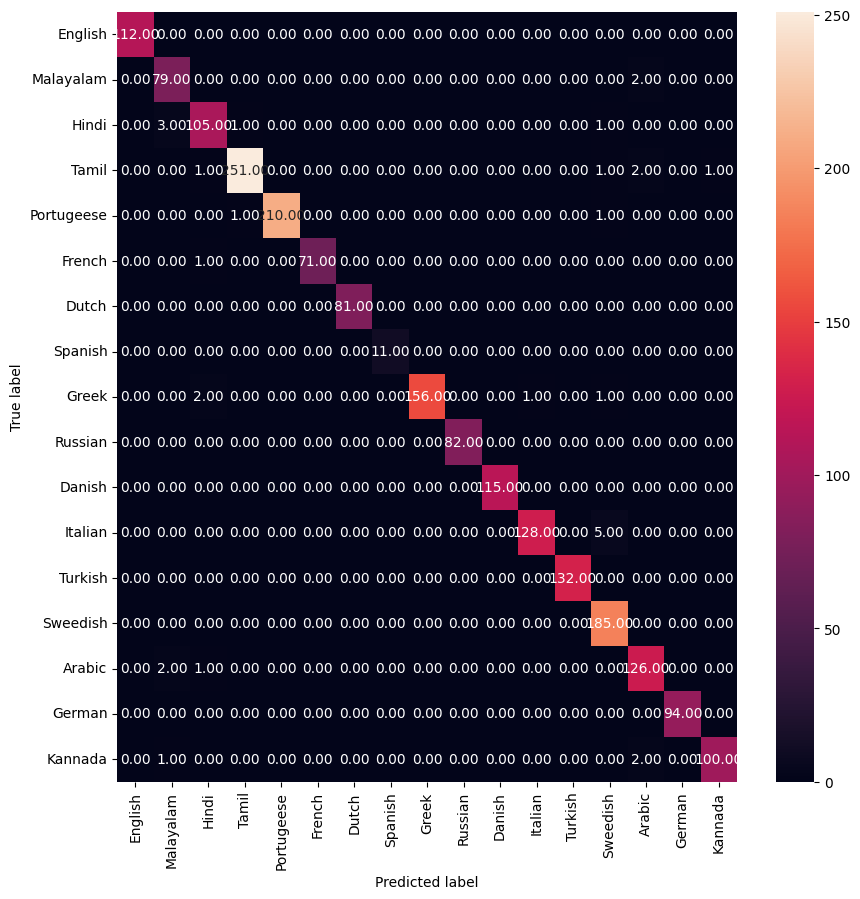

In [117]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=1, 
    layer_types=['LSTM'], 
    layer_units=[64], 
    input_shape=(None, 16), 
)

TrainModel(model, 25, 'FT_LSTM1', X_train, X_test, y_train, y_test)

- Model : 2

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_27 (Reshape)        (None, 16, 1)             0         
                                                                 
 lstm_16 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_40 (Dropout)        (None, 64)                0         
                                                                 
 dense_77 (Dense)            (None, 17)                1105      
                                                                 
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
_________________________________________________________________


2023-05-03 21:28:21.697821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:28:21.699426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:28:21.700467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/65 [===========>..................] - ETA: 0s 

2023-05-03 21:28:21.930905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:28:21.932346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:28:21.933332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 0s 2ms/step
Accuracy	:	0.9859767891682786
Precision	:	0.9866171098878008
Recall	:	0.9859767891682786
F1 score	:	0.9859757857252998


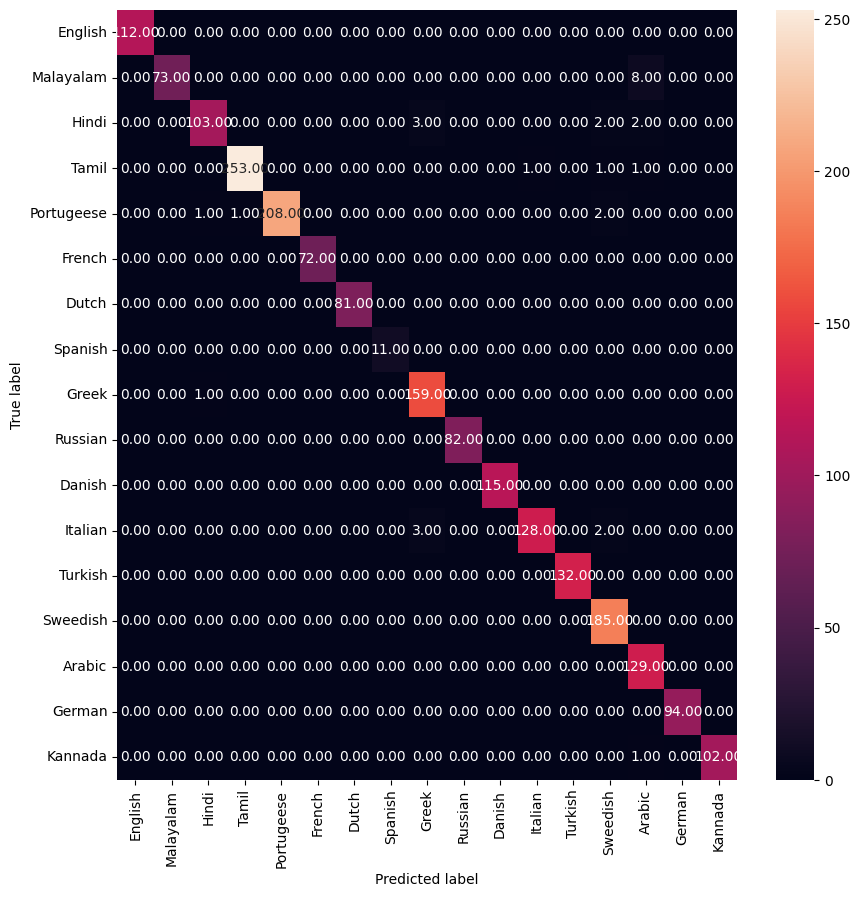

In [118]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=2, 
    layer_types=['LSTM', 'Dropout'],
    layer_units=[64, 0.2],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_LSTM2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_28 (Reshape)        (None, 16, 1)             0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_41 (Dropout)        (None, 64)                0         
                                                                 
 dense_78 (Dense)            (None, 32)                2080      
                                                                 
 dense_79 (Dense)            (None, 17)                561       
                                                                 
Total params: 19,537
Trainable params: 19,537
Non-trainable params: 0
_________________________________________________________________


2023-05-03 21:28:23.007786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:28:23.009274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:28:23.010790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/65 [===========>..................] - ETA: 0s 

2023-05-03 21:28:23.243533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:28:23.245294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:28:23.246453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 0s 2ms/step
Accuracy	:	0.9821083172147002
Precision	:	0.9823588936292882
Recall	:	0.9821083172147002
F1 score	:	0.9820787250487943


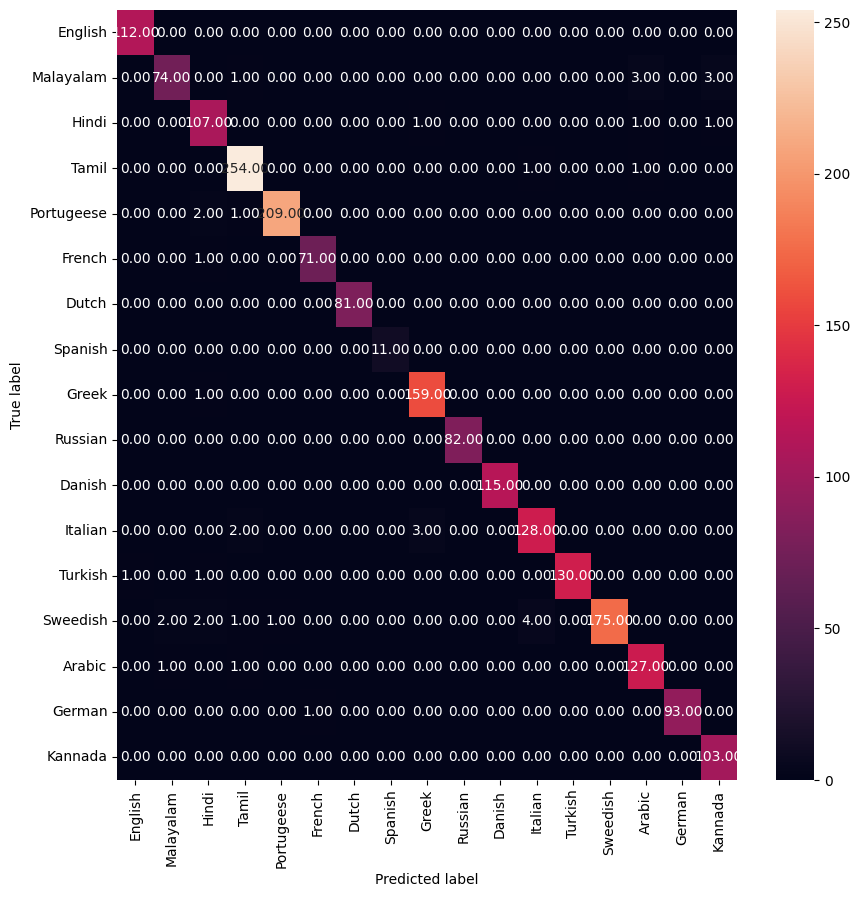

In [119]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=3, 
    layer_types=['LSTM', 'Dropout', 'Dense'],
    layer_units=[64, 0.2, 32],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_LSTM3', X_train, X_test, y_train, y_test)

- Model : 4

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_29 (Reshape)        (None, 16, 1)             0         
                                                                 
 lstm_18 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_80 (Dense)            (None, 32)                2080      
                                                                 
 dropout_43 (Dropout)        (None, 32)                0         
                                                                 
 dense_81 (Dense)            (None, 17)                561       
                                                                 
Total params: 19,537
Trainable params: 19,537
Non-tra

2023-05-03 21:28:24.628338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:28:24.629808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:28:24.630823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/65 [===========>..................] - ETA: 0s 

2023-05-03 21:28:24.870408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 21:28:24.871914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 21:28:24.873092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 0s 2ms/step
Accuracy	:	0.9854932301740812
Precision	:	0.9860302524075496
Recall	:	0.9854932301740812
F1 score	:	0.9856144659299213


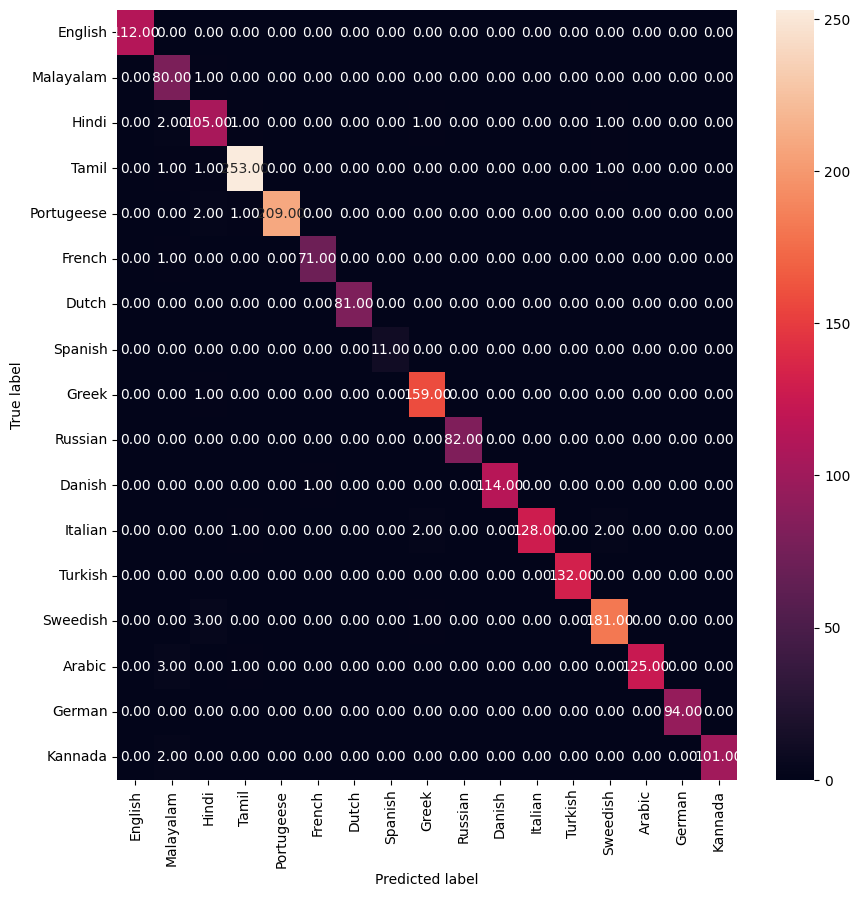

In [120]:
model = createModel(
    model_type = 'LSTM', 
    num_layers=4, 
    layer_types=['LSTM', 'Dropout', 'Dense', 'Dropout'],
    layer_units=[64, 0.2, 32, 0.2],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_LSTM4', X_train, X_test, y_train, y_test)

#### Convolutional Nural Network

- Model : 1

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_30 (Reshape)        (None, 16, 1)             0         
                                                                 
 conv1d_17 (Conv1D)          (None, 14, 64)            256       
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 7, 64)            0         
 g1D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 7, 64)             0         
                                                                 
 flatten_11 (Flatten)        (None, 448)               0         
                                                                 
 dense_82 (Dense)            (None, 17)                7633      
                                                     

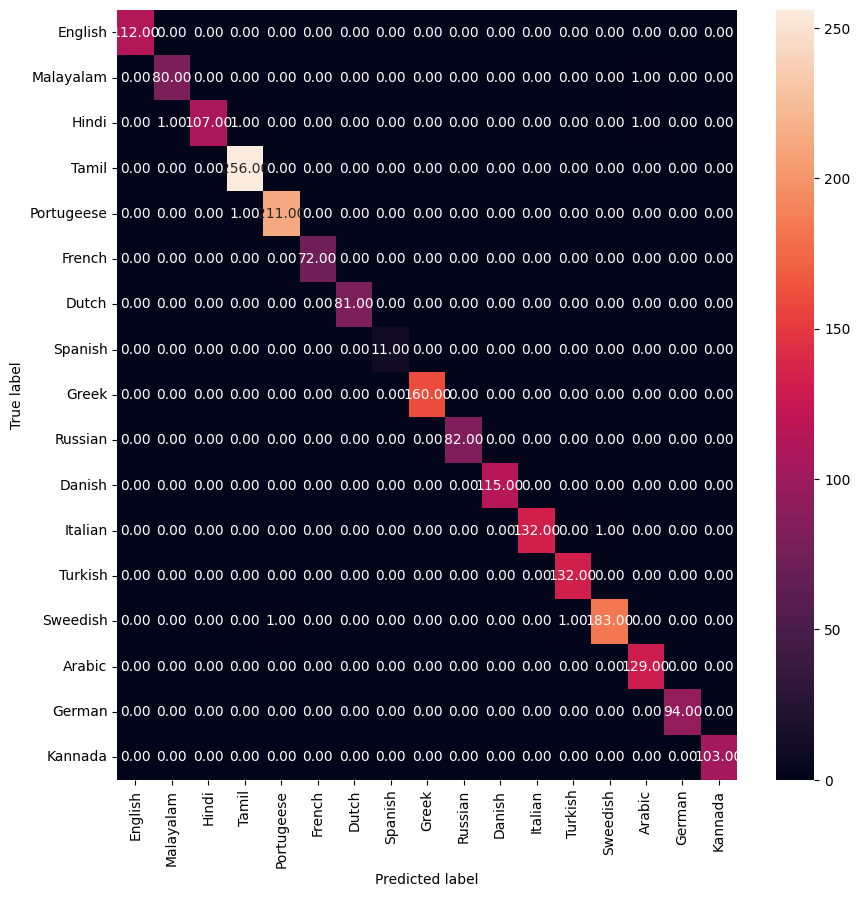

In [121]:
model = createModel(
    model_type = 'Convolutional1D', 
    num_layers=4, 
    layer_types=['Conv1D', 'MaxPooling1D', 'Dropout', 'Flatten'],
    layer_units=[64, 2, 0.2, 32],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_CNN1', X_train, X_test, y_train, y_test)

- Model : 2

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_31 (Reshape)        (None, 16, 1)             0         
                                                                 
 conv1d_18 (Conv1D)          (None, 14, 64)            256       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 7, 64)            0         
 g1D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 7, 64)             0         
                                                                 
 conv1d_19 (Conv1D)          (None, 5, 64)             12352     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                

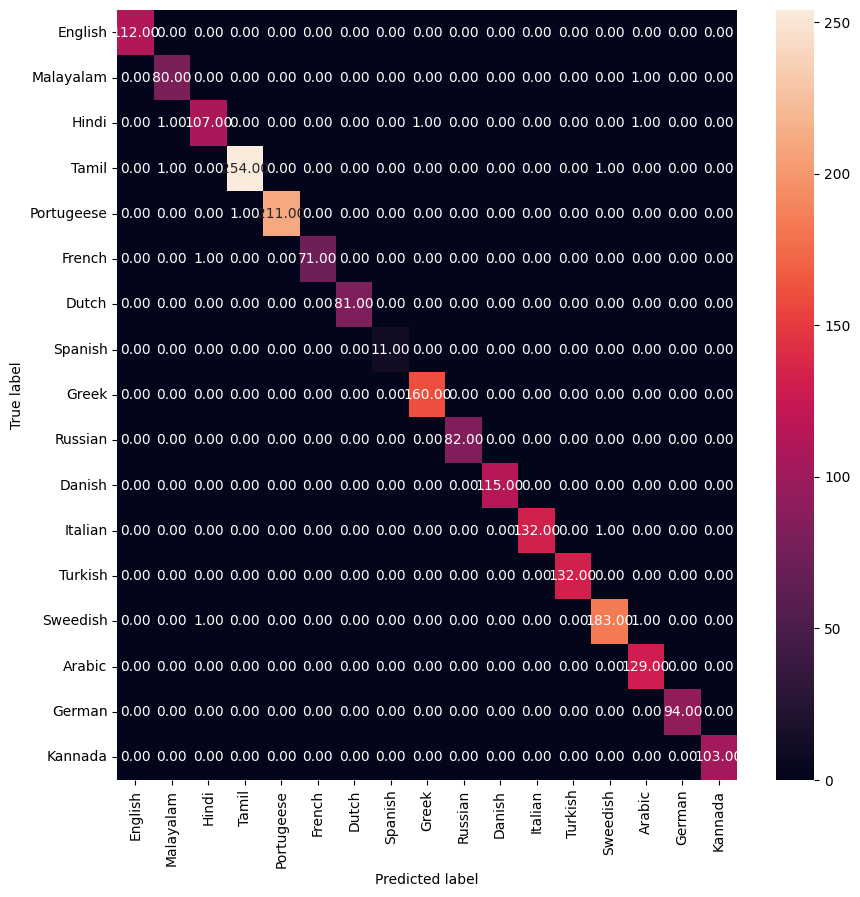

In [122]:
model = createModel(
    model_type = 'Convolutional1D', 
    num_layers=6, 
    layer_types=['Conv1D', 'MaxPooling1D', 'Dropout', 'Conv1D', 'MaxPooling1D', 'Flatten'],
    layer_units=[64, 2, 0.2, 64, 2],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_CNN2', X_train, X_test, y_train, y_test)

- Model : 3

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_32 (Reshape)        (None, 16, 1)             0         
                                                                 
 conv1d_20 (Conv1D)          (None, 14, 64)            256       
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 7, 64)            0         
 g1D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 7, 64)             0         
                                                                 
 conv1d_21 (Conv1D)          (None, 5, 64)             12352     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                

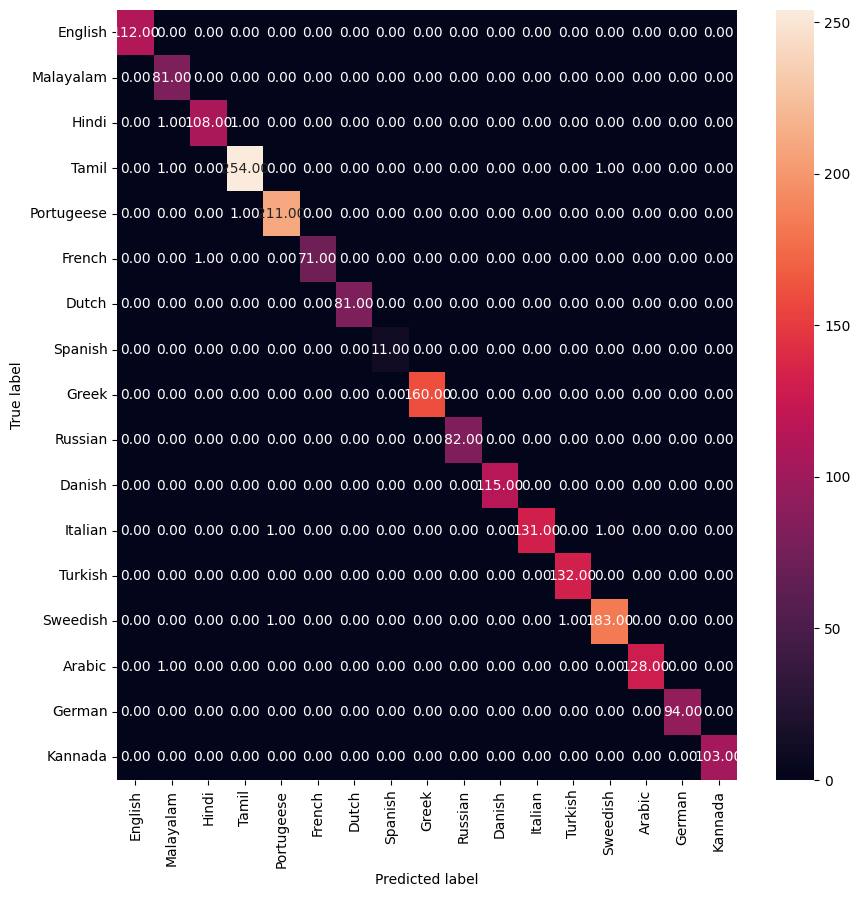

In [123]:
model = createModel(
    model_type = 'Convolutional2D', 
    num_layers=6, 
    layer_types=['Conv2D', 'MaxPooling2D', 'Dropout', 'Conv2D', 'MaxPooling2D', 'Flatten'],
    layer_units=[64, 2, 0.2, 64, 2],
    input_shape=(None, 16), 
)
TrainModel(model, 25, 'FT_CNN3', X_train, X_test, y_train, y_test)